## Outline



In [1]:
# import the pytorch library into environment and check its version
import os
import torch
print("Using torch", torch.__version__)

Using torch 2.1.0+cu118


Import some required libraries into our environment:

In [2]:
!pip install karateclub

Let's start installing PyG by `pip`. The version of PyG should match the current version of PyTorch. Here we follow the [instruction](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html) of PyG:

In [3]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.12.0+cu113.html
!pip install ogb  # for datasets

Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu113.html


In [4]:
!pip install optuna

In [5]:
!pip install torchvision

In [6]:
from torch_geometric import nn
from torch_geometric.datasets import DeezerEurope, Twitch

In [7]:
import networkx as nx
from karateclub import FeatherNode, ASNE, SINE

### Base Model

In [8]:
def get_num_classes(data):
  num_classes = 0
  num_classes = len(data.y.unique())

  return num_classes

Load Datasets

In [9]:
dataset_TwitchDE = Twitch('/tmp/DE', 'DE')
data_TwitchDE = dataset_TwitchDE[0]

In [10]:
num_nodes_TwitchDE = data_TwitchDE.num_nodes
print('data_TwitchDE has {} nodes'.format(num_nodes_TwitchDE))

num_edges_TwitchDE = data_TwitchDE.num_edges
print('data_TwitchDE has {} edges'.format(num_edges_TwitchDE))

num_classes_TwitchDE = get_num_classes(data_TwitchDE)
print('data_TwitchDE has {} classes'.format(num_classes_TwitchDE))

num_features_TwitchDE = data_TwitchDE.num_features
print('data_TwitchDE has {} features'.format(num_features_TwitchDE))

data_TwitchDE has 9498 nodes
data_TwitchDE has 315774 edges
data_TwitchDE has 2 classes
data_TwitchDE has 128 features


In [11]:
dataset_DeezerEurope = DeezerEurope('/tmp/DeezerEurope')
data_DeezerEurope = dataset_DeezerEurope[0]

In [12]:
num_nodes_DeezerEurope = data_DeezerEurope.num_nodes
print('data_DeezerEurope has {} nodes'.format(num_nodes_DeezerEurope))

num_edges_DeezerEurope = data_DeezerEurope.num_edges
print('data_DeezerEurope has {} edges'.format(num_edges_DeezerEurope))

num_classes_DeezerEurope = get_num_classes(data_DeezerEurope)
print('data_DeezerEurope has {} classes'.format(num_classes_DeezerEurope))

num_features_DeezerEurope = data_DeezerEurope.num_features
print('data_DeezerEurope has {} features'.format(num_features_DeezerEurope))

data_DeezerEurope has 28281 nodes
data_DeezerEurope has 185504 edges
data_DeezerEurope has 2 classes
data_DeezerEurope has 128 features


In [13]:
# Set the seed for PyTorch random number generator
torch.manual_seed(100)

node_feature = data_TwitchDE.x
num_nodes = data_TwitchDE.num_nodes


# Number of nodes
num_nodes = data_TwitchDE.num_nodes

# Create masks
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# Example: Assign 60% to train, 20% to validation, and 20% to test
num_train = int(num_nodes * 0.6)
num_val = int(num_nodes * 0.2)

train_mask[:num_train] = True
val_mask[num_train:num_train+num_val] = True
test_mask[num_train+num_val:] = True

# Shuffle the masks if needed
perm = torch.randperm(num_nodes)
train_mask = train_mask[perm]
val_mask = val_mask[perm]
test_mask = test_mask[perm]

# Assign the masks to the dataset
data_TwitchDE.train_mask = train_mask
data_TwitchDE.val_mask = val_mask
data_TwitchDE.test_mask = test_mask

# Now you can use these masks to select features
TwitchDEtrain_node_feature = data_TwitchDE.x[data_TwitchDE.train_mask]
TwitchDEvalid_node_feature = data_TwitchDE.x[data_TwitchDE.val_mask]
TwitchDEtest_node_feature = data_TwitchDE.x[data_TwitchDE.test_mask]

# TwitchDEtrain_node_feature = node_feature[data_TwitchDE.train_mask]
# TwitchDEvalid_node_feature = node_feature[data_TwitchDE.val_mask]
# TwitchDEtest_node_feature = node_feature[data_TwitchDE.test_mask]

print("number of nodes in train set,", TwitchDEtrain_node_feature.shape[0])
print("number of nodes in valid set,", TwitchDEvalid_node_feature.shape[0])
print("number of nodes in test set,", TwitchDEtest_node_feature.shape[0])

number of nodes in train set, 5698
number of nodes in valid set, 1899
number of nodes in test set, 1901


In [14]:
data_TwitchDE

Data(x=[9498, 128], edge_index=[2, 315774], y=[9498], train_mask=[9498], val_mask=[9498], test_mask=[9498])

In [15]:
# Number of nodes
num_nodes = data_DeezerEurope.num_nodes

# Create masks
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# Example: Assign 60% to train, 20% to validation, and 20% to test
num_train = int(num_nodes * 0.6)
num_val = int(num_nodes * 0.2)

train_mask[:num_train] = True
val_mask[num_train:num_train+num_val] = True
test_mask[num_train+num_val:] = True

# Shuffle the masks if needed
perm = torch.randperm(num_nodes)
train_mask = train_mask[perm]
val_mask = val_mask[perm]
test_mask = test_mask[perm]

# Assign the masks to the dataset
data_DeezerEurope.train_mask = train_mask
data_DeezerEurope.val_mask = val_mask
data_DeezerEurope.test_mask = test_mask

# Now you can use these masks to select features
data_DeezerEuropetrain_node_feature = data_DeezerEurope.x[data_DeezerEurope.train_mask]
data_DeezerEuropevalid_node_feature = data_DeezerEurope.x[data_DeezerEurope.val_mask]
data_DeezerEuropetest_node_feature = data_DeezerEurope.x[data_DeezerEurope.test_mask]

# TwitchDEtrain_node_feature = node_feature[data_DeezerEurope.train_mask]
# TwitchDEvalid_node_feature = node_feature[data_DeezerEurope.val_mask]
# TwitchDEtest_node_feature = node_feature[data_DeezerEurope.test_mask]

print("number of nodes in train set,", data_DeezerEuropetrain_node_feature.shape[0])
print("number of nodes in valid set,", data_DeezerEuropevalid_node_feature.shape[0])
print("number of nodes in test set,", data_DeezerEuropetest_node_feature.shape[0])

number of nodes in train set, 16968
number of nodes in valid set, 5656
number of nodes in test set, 5657


In [16]:
data_DeezerEurope

Data(x=[28281, 128], edge_index=[2, 185504], y=[28281], train_mask=[28281], val_mask=[28281], test_mask=[28281])

### SAGECONV Only

In [17]:
import numpy as np

In [18]:
import matplotlib.pyplot as plt

In [19]:
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.SAGEconv1 = SAGEConv(in_channels, hidden_channels)
        self.SAGEconv2 = SAGEConv(hidden_channels, out_channels)
        self.act = torch.nn.ReLU()

    def forward(self,node_feature, edge_index):

        output = self.SAGEconv1(node_feature, edge_index)
        output = self.act(output)
        output = self.SAGEconv2(output, edge_index)

        return output

In [ ]:
# hidden_channels = 64
# num_features = num_features_TwitchDE
# num_classes = get_num_classes(data_TwitchDE) # please write down the number of classes 2

# model = GraphSAGE(num_features, hidden_channels, num_classes)
# import torch.optim as optim
# import torch.nn as nn

# optimizer = optim.Adam(model.parameters(), lr=2e-5)
# loss_fn = nn.CrossEntropyLoss()

In [20]:
def train(model, data, optimizer, loss_fn):

    loss = 0

    model.train() # put the model into train mode
    optimizer.zero_grad() # clear the gradients calculated from the last batch
    y_pred = model(data.x, data.edge_index) # get the prediction by model
    loss = loss_fn(y_pred[data.train_mask], data.y[data.train_mask]) # calculate the loss between our predictions and the actual labels
    loss.backward() # calculate the gradients of each parameter
    optimizer.step() # update the parameters by taking an optimizer step


    return loss

In [21]:
@torch.no_grad()
def test(model, data):

    accuracy_list = [0, 0, 0]

    model.eval() # put the model into eval mode
    y_pred = model(data.x, data.edge_index).argmax(dim=1) # get the prediction by model
    accuracy_list[0] += (y_pred[data.train_mask] == data.y[data.train_mask]).sum()/len(y_pred[data.train_mask])
    accuracy_list[1] += (y_pred[data.val_mask] == data.y[data.val_mask]).sum()/len(y_pred[data.val_mask])
    accuracy_list[2] += (y_pred[data.test_mask] == data.y[data.test_mask]).sum()/len(y_pred[data.test_mask])

    return accuracy_list

In [22]:
def epoch_acc_plot(epochs_list=range(1, 51), train_acc_list=None, val_acc_list=None, test_acc_list=None):
  # Plotting training, validation, and test accuracy over epochs
  plt.figure(figsize=(10, 6))
  plt.plot(epochs_list, train_acc_list, label='Training Accuracy')
  plt.plot(epochs_list, val_acc_list, label='Validation Accuracy')
  plt.plot(epochs_list, test_acc_list, label='Test Accuracy')

  plt.title('Training, Validation, and Test Accuracy Over Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)
  plt.show()

In [23]:
import torch.optim as optim
import torch.nn as nn

hidden_channels = 64
num_features = num_features_TwitchDE
num_classes = get_num_classes(data_TwitchDE) # please write down the number of classes

model = GraphSAGE(num_features, hidden_channels, num_classes)
optimizer = optim.Adam(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
train_acc_list=[]
val_acc_list=[]
test_acc_list=[]
epochs = 50
best_val_acc = final_test_acc = 0
for epoch in range(1, epochs + 1):
    loss = train(model, data_TwitchDE, optimizer, loss_fn)
    #print(loss)
    train_acc, val_acc, test_acc = test(model, data_TwitchDE)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    test_acc_list.append(test_acc)
    #print(train_acc, val_acc, test_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        final_test_acc = test_acc
len_test_list = len(test_acc_list)
mean_value = np.mean(test_acc_list)
std_error = np.std(test_acc_list) / np.sqrt(len_test_list)
print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))
print("after {} epochs' training, the mean test accuracy is {}".format(epochs, mean_value))
print("after {} epochs' training, the standard error of accuracy is {}".format(epochs, std_error))

after 50 epochs' training, the best test accuracy is 0.5439242720603943
after 50 epochs' training, the mean test accuracy is 0.513214111328125
after 50 epochs' training, the standard error of accuracy is 0.0029688690535517215


In [24]:
hidden_channels = 64
num_features = num_features_DeezerEurope
num_classes = get_num_classes(data_DeezerEurope) # please write down the number of classes

model = GraphSAGE(num_features, hidden_channels, num_classes)
optimizer = optim.Adam(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
train_acc_list=[]
val_acc_list=[]
test_acc_list=[]

epochs = 50
best_val_acc = final_test_acc = 0
for epoch in range(1, epochs + 1):
    loss = train(model, data_DeezerEurope, optimizer, loss_fn)
    #print(loss)
    train_acc, val_acc, test_acc = test(model, data_DeezerEurope)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    test_acc_list.append(test_acc)
    #print(train_acc, val_acc, test_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        final_test_acc = test_acc
len_test_list = len(test_acc_list)
mean_value = np.mean(test_acc_list)
std_error = np.std(test_acc_list) / np.sqrt(len_test_list)
print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))
print("after {} epochs' training, the mean test accuracy is {}".format(epochs, mean_value))
print("after {} epochs' training, the standard error of accuracy is {}".format(epochs, std_error))

after 50 epochs' training, the best test accuracy is 0.5320841670036316
after 50 epochs' training, the mean test accuracy is 0.5176347494125366
after 50 epochs' training, the standard error of accuracy is 0.0014772297864407266


In [25]:
import torch.nn.functional as F
import optuna


def objective(trial, data):
    # 提议超参数 Hyperparameters
    hidden_channels = trial.suggest_categorical('hidden_channels', [16, 32, 64, 128])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-3)
    optimizer_name = trial.suggest_categorical('optimizer', [optim.Adam,optim.AdamW,optim.RMSprop,optim.Adagrad,optim.Adamax,optim.Adam,optim.SGD])
    epochs = trial.suggest_categorical('epochs', [25, 50, 75, 100])


    num_features = data.num_features
    num_classes = get_num_classes(data)

    model = GraphSAGE(num_features, hidden_channels, num_classes)
    loss_fn = nn.CrossEntropyLoss()
    best_val_acc = final_test_acc = 0
    patience = 10  # 设置早停的耐心值
    min_delta = 0.001  # 设置改善的最小阈值 threshold

    optimizer = optimizer_name(model.parameters(), lr=learning_rate)
    for epoch in range(1, epochs+1):
        train_loss = train(model, data, optimizer, loss_fn)
        train_acc, val_acc, test_acc = test(model, data)
        # 检查是否有改善
        if val_acc > best_val_acc + min_delta:
            best_val_acc = val_acc
            final_test_acc = test_acc
            no_improve_count = 0
        else:
            no_improve_count += 1

        # 如果连续多个 epochs 没有显著改善，则停止训练
        if no_improve_count >= patience:
            break


    return final_test_acc



In [ ]:
study = optuna.create_study(direction='maximize')

# 运行优化，这里假设已经有了一个名为 data 的数据对象
study.optimize(lambda trial: objective(trial, data_TwitchDE), n_trials=25)

# 打印出最佳参数
print("最佳参数 Best Hyperparams: ", study.best_params)
print("最佳测试准确率 Best Accuracy: ", study.best_value)

In [ ]:
study = optuna.create_study(direction='maximize')

# 运行优化，这里假设已经有了一个名为 data 的数据对象
study.optimize(lambda trial: objective(trial, data_DeezerEurope), n_trials=25)

# 打印出最佳参数
print("最佳参数 Best Hyperparams:: ", study.best_params)
print("最佳测试准确率 Best Accuracy: ", study.best_value)

### With Deep Embedding

General Calculation and train test function for all models:

#### Embedding

##### Twitch

In [27]:
from karateclub import FeatherNode, ASNE, Node2Vec
import torch_geometric.utils as pyg_utils
from scipy.sparse import coo_matrix
# graph (NetworkX graph) - The graph to be embedded.
G_TwitchDE = pyg_utils.to_networkx(data_TwitchDE, to_undirected=True)
# X (Scipy COO or Numpy array) - The matrix of node features.
X_TwitchDE = data_TwitchDE.x.numpy()  # Convert to NumPy array if it's a tensor
# class FeatherNode(reduction_dimensions: int = 64, svd_iterations: int = 20, theta_max: float = 2.5, eval_points: int = 25, order: int = 5, seed: int = 42)
feather_TwitchDE = FeatherNode(reduction_dimensions  = 16)
feather_TwitchDE.fit(G_TwitchDE, X_TwitchDE)
feather_embedding_TwitchDE = feather_TwitchDE.get_embedding()

In [28]:
torch.tensor(feather_embedding_TwitchDE, dtype=torch.float).size()

torch.Size([9498, 4000])

In [29]:
#classASNE(dimensions: int = 128, workers: int = 4, epochs: int = 100, down_sampling: float = 0.0001, learning_rate: float = 0.05, min_count: int = 1, seed: int = 42)
ASNE_TwitchDE = ASNE()
# Convert the dense numpy array to a COO sparse matrix
X_coo_TwitchDE = coo_matrix(X_TwitchDE)
ASNE_TwitchDE.fit(G_TwitchDE, X_coo_TwitchDE)
ASNE_embedding_TwitchDE = ASNE_TwitchDE.get_embedding()

In [30]:
torch.tensor(ASNE_embedding_TwitchDE, dtype=torch.float).size()

torch.Size([9498, 128])

In [31]:
from karateclub import BANE
# class BANE(dimensions: int = 32, svd_iterations: int = 20, seed: int = 42, alpha: float = 0.3, iterations: int = 100, binarization_iterations: int = 20)
BANE_TwitchDE = BANE(dimensions = 16)
BANE_TwitchDE.fit(G_TwitchDE, X_coo_TwitchDE)
BANE_embedding_TwitchDE = BANE_TwitchDE.get_embedding()

In [32]:
torch.tensor(BANE_embedding_TwitchDE, dtype=torch.float).size()

torch.Size([9498, 16])

##### DeezerEurope

In [33]:
G_DeezerEurope = pyg_utils.to_networkx(data_DeezerEurope, to_undirected=True)
X_DeezerEurope = data_DeezerEurope.x.numpy()  # Convert to NumPy array if it's a tensor
feather_DeezerEurope = FeatherNode(reduction_dimensions  = 16)
feather_DeezerEurope.fit(G_DeezerEurope, X_DeezerEurope)
feather_embedding_DeezerEurope = feather_DeezerEurope.get_embedding()

In [34]:
torch.tensor(feather_embedding_DeezerEurope, dtype=torch.float).size()

torch.Size([28281, 4000])

In [35]:
ASNE_DeezerEurope = ASNE()
# Convert the dense numpy array to a COO sparse matrix
X_coo_DeezerEurope = coo_matrix(X_DeezerEurope)
ASNE_DeezerEurope.fit(G_DeezerEurope, X_coo_DeezerEurope)
ASNE_embedding_DeezerEurope = ASNE_DeezerEurope.get_embedding()

In [36]:
torch.tensor(ASNE_embedding_DeezerEurope, dtype=torch.float).size()

torch.Size([28281, 128])

In [37]:
BANE_DeezerEurope = BANE(dimensions = 16)
BANE_DeezerEurope.fit(G_DeezerEurope, X_coo_DeezerEurope)
BANE_embedding_DeezerEurope = BANE_DeezerEurope.get_embedding()

In [38]:
torch.tensor(BANE_embedding_DeezerEurope, dtype=torch.float).size()

torch.Size([28281, 16])

In [ ]:
# G_DeezerEurope = pyg_utils.to_networkx(data_DeezerEurope, to_undirected=True)

# X_DeezerEurope = data_DeezerEurope.x.numpy()  # Convert to NumPy array if it's a tensor
# feather_DeezerEurope = FeatherNode(reduction_dimensions = 16)
# feather_DeezerEurope.fit(G_DeezerEurope, X_DeezerEurope)
# feather_embedding_DeezerEurope = feather_DeezerEurope.get_embedding()

# ASNE_DeezerEurope = ASNE()
# # Convert the dense numpy array to a COO sparse matrix
# X_coo_DeezerEurope = coo_matrix(X_DeezerEurope)
# ASNE_DeezerEurope.fit(G_DeezerEurope, X_coo_DeezerEurope)
# ASNE_embedding_DeezerEurope = ASNE_DeezerEurope.get_embedding()

# SINE_DeezerEurope = SINE(dimensions = 16)
# SINE_DeezerEurope.fit(G_DeezerEurope, X_coo_DeezerEurope)
# SINE_embedding_DeezerEurope = SINE_DeezerEurope.get_embedding()

#### Train and Test Function

In [39]:
def trainWithEmbedding(model, data, optimizer, loss_fn, Attributed_node_embedding):

    loss = 0

    model.train() # put the model into train mode
    optimizer.zero_grad() # clear the gradients calculated from the last batch
    y_pred = model(data.x, data.edge_index, Attributed_node_embedding) # get the prediction by model
    loss = loss_fn(y_pred[data.train_mask], data.y[data.train_mask]) # calculate the loss between our predictions and the actual labels
    loss.backward() # calculate the gradients of each parameter
    optimizer.step() # update the parameters by taking an optimizer step


    return loss

In [40]:
@torch.no_grad()
def testWithEmbedding(model, data, Attributed_node_embedding):

    accuracy_list = [0, 0, 0]

    model.eval() # put the model into eval mode
    y_pred = model(data.x, data.edge_index, Attributed_node_embedding).argmax(dim=1) # get the prediction by model
    accuracy_list[0] += (y_pred[data.train_mask] == data.y[data.train_mask]).sum()/len(y_pred[data.train_mask])
    accuracy_list[1] += (y_pred[data.val_mask] == data.y[data.val_mask]).sum()/len(y_pred[data.val_mask])
    accuracy_list[2] += (y_pred[data.test_mask] == data.y[data.test_mask]).sum()/len(y_pred[data.test_mask])

    return accuracy_list

In [41]:
def objectiveWithEmbedding(trial, data, embedding, modelWithEmbedding):
    # 提议超参数
    hidden_channels = trial.suggest_categorical('hidden_channels', [16, 32, 64, 128])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-3)
    optimizer_name = trial.suggest_categorical('optimizer', [optim.Adam,optim.AdamW,optim.RMSprop,optim.Adagrad,optim.Adamax,optim.Adam,optim.SGD])
    epochs = trial.suggest_categorical('epochs', [25, 50, 75, 100])


    num_features = data.num_features
    num_classes = get_num_classes(data)

    model = modelWithEmbedding(num_features, hidden_channels, num_classes, embedding)
    loss_fn = nn.CrossEntropyLoss()
    best_val_acc = final_test_acc = 0
    patience = 10  # 设置早停的耐心值
    min_delta = 0.001  # 设置改善的最小阈值

    optimizer = optimizer_name(model.parameters(), lr=learning_rate)
    for epoch in range(1, epochs+1):
        train_loss = trainWithEmbedding(model, data, optimizer, loss_fn, embedding)
        train_acc, val_acc, test_acc = testWithEmbedding(model, data, embedding)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        test_acc_list.append(test_acc)
        # 检查是否有改善
        if val_acc > best_val_acc + min_delta:
            best_val_acc = val_acc
            final_test_acc = test_acc
            no_improve_count = 0
        else:
            no_improve_count += 1

        # 如果连续多个 epochs 没有显著改善，则停止训练
        if no_improve_count >= patience:
            break


    return final_test_acc

#### Enhanced

In [42]:
class EnhancedGraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, Attributed_node_embedding):
        super().__init__()
        self.SAGEconv1 = SAGEConv(in_channels + Attributed_node_embedding.shape[1], hidden_channels)
        self.SAGEconv2 = SAGEConv(hidden_channels, out_channels)
        self.act = torch.nn.ReLU()

    def forward(self,node_feature, edge_index, Attributed_node_embedding):
        # cat the features before graphsage layer
        output = torch.cat([node_feature, torch.tensor(Attributed_node_embedding, dtype=torch.float)], dim=1)
        output = self.SAGEconv1(output, edge_index)
        output = self.act(output)
        output = self.SAGEconv2(output, edge_index)

        return output

#####Twitch

In [43]:
import torch.optim as optim
import torch.nn as nn

hidden_channels = 64
num_features = num_features_TwitchDE
num_classes = get_num_classes(data_TwitchDE) # please write down the number of classes

feather_enhanced_twitch = EnhancedGraphSAGE(num_features, hidden_channels, num_classes, feather_embedding_TwitchDE)
optimizer = optim.Adam(feather_enhanced_twitch.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

In [44]:
print(feather_enhanced_twitch)

EnhancedGraphSAGE(
  (SAGEconv1): SAGEConv(4128, 64, aggr=mean)
  (SAGEconv2): SAGEConv(64, 2, aggr=mean)
  (act): ReLU()
)


In [45]:
torch.cat([node_feature, torch.tensor(BANE_embedding_TwitchDE, dtype=torch.float)], dim=1).size()

torch.Size([9498, 144])

In [46]:
train_acc_list=[]
val_acc_list=[]
test_acc_list=[]

epochs = 50
best_val_acc = final_test_acc = 0
for epoch in range(1, epochs + 1):
    loss = trainWithEmbedding(feather_enhanced_twitch, data_TwitchDE, optimizer, loss_fn, feather_embedding_TwitchDE)
    #print(loss)
    train_acc, val_acc, test_acc = testWithEmbedding(feather_enhanced_twitch, data_TwitchDE, feather_embedding_TwitchDE)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    test_acc_list.append(test_acc)
    #print(train_acc, val_acc, test_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        final_test_acc = test_acc
len_test_list = len(test_acc_list)
mean_value = np.mean(test_acc_list)
std_error = np.std(test_acc_list) / np.sqrt(len_test_list)
print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))
print("after {} epochs' training, the mean test accuracy is {}".format(epochs, mean_value))
print("after {} epochs' training, the standard error of accuracy is {}".format(epochs, std_error))

after 50 epochs' training, the best test accuracy is 0.6443976759910583
after 50 epochs' training, the mean test accuracy is 0.6201788187026978
after 50 epochs' training, the standard error of accuracy is 0.002060190638773139


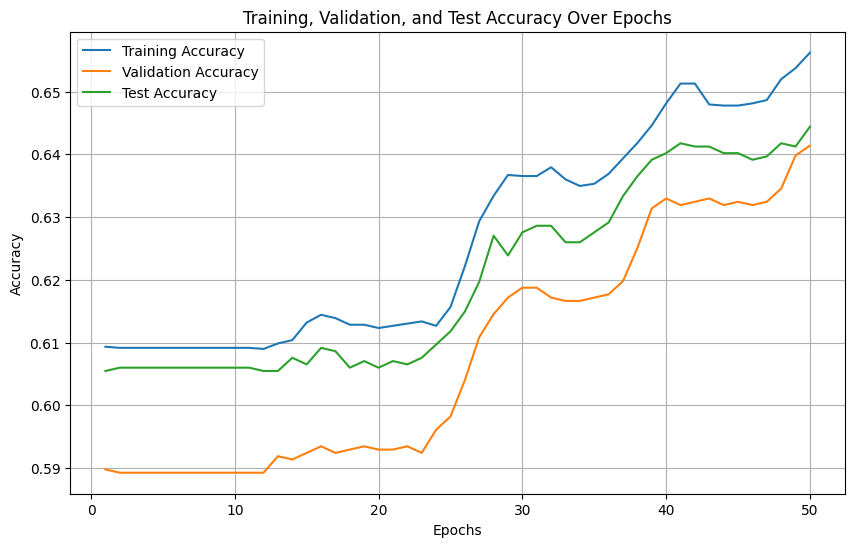

In [47]:
epoch_acc_plot(range(1, 51), train_acc_list, val_acc_list, test_acc_list)

In [48]:
hidden_channels = 64
num_features = num_features_TwitchDE
num_classes = get_num_classes(data_TwitchDE) # please write down the number of classes

ASNE_enhanced_twitch = EnhancedGraphSAGE(num_features, hidden_channels, num_classes, ASNE_embedding_TwitchDE)
optimizer = optim.Adam(ASNE_enhanced_twitch.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
train_acc_list=[]
val_acc_list=[]
test_acc_list=[]

epochs = 50
best_val_acc = final_test_acc = 0
for epoch in range(1, epochs + 1):
    loss = trainWithEmbedding(ASNE_enhanced_twitch, data_TwitchDE, optimizer, loss_fn, ASNE_embedding_TwitchDE)
    #print(loss)
    train_acc, val_acc, test_acc = testWithEmbedding(ASNE_enhanced_twitch, data_TwitchDE, ASNE_embedding_TwitchDE)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    test_acc_list.append(test_acc)
    #print(train_acc, val_acc, test_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        final_test_acc = test_acc
len_test_list = len(test_acc_list)
mean_value = np.mean(test_acc_list)
std_error = np.std(test_acc_list) / np.sqrt(len_test_list)
print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))
print("after {} epochs' training, the mean test accuracy is {}".format(epochs, mean_value))
print("after {} epochs' training, the standard error of accuracy is {}".format(epochs, std_error))

after 50 epochs' training, the best test accuracy is 0.40504997968673706
after 50 epochs' training, the mean test accuracy is 0.40034717321395874
after 50 epochs' training, the standard error of accuracy is 0.00040621883335538765


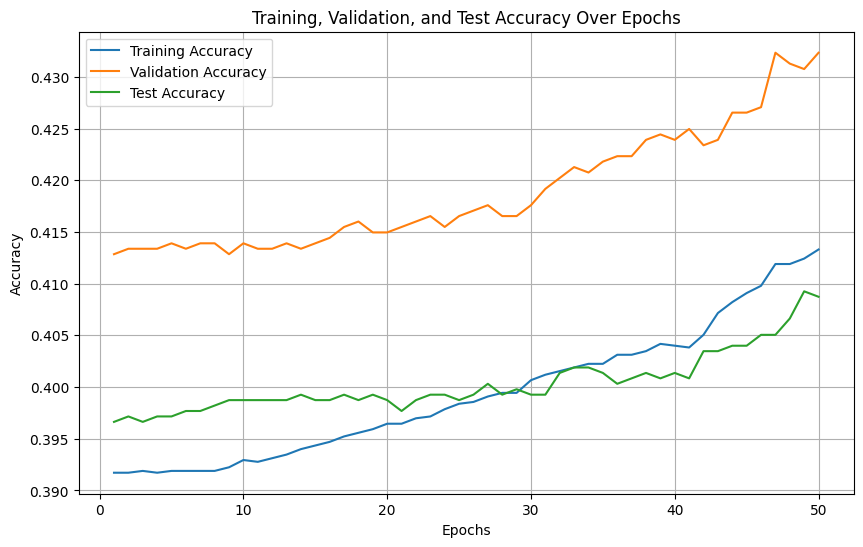

In [49]:
epoch_acc_plot(range(1, 51), train_acc_list, val_acc_list, test_acc_list)

In [50]:
hidden_channels = 64
num_features = num_features_TwitchDE
num_classes = get_num_classes(data_TwitchDE) # please write down the number of classes

BANE_enhanced_twitch = EnhancedGraphSAGE(num_features, hidden_channels, num_classes, BANE_embedding_TwitchDE)
optimizer = optim.Adam(BANE_enhanced_twitch.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
train_acc_list=[]
val_acc_list=[]
test_acc_list=[]

epochs = 50
best_val_acc = final_test_acc = 0
for epoch in range(1, epochs + 1):
    loss = trainWithEmbedding(BANE_enhanced_twitch, data_TwitchDE, optimizer, loss_fn, BANE_embedding_TwitchDE)
    #print(loss)
    train_acc, val_acc, test_acc = testWithEmbedding(BANE_enhanced_twitch, data_TwitchDE, BANE_embedding_TwitchDE)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    test_acc_list.append(test_acc)
    #print(train_acc, val_acc, test_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        final_test_acc = test_acc
len_test_list = len(test_acc_list)
mean_value = np.mean(test_acc_list)
std_error = np.std(test_acc_list) / np.sqrt(len_test_list)
print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))
print("after {} epochs' training, the mean test accuracy is {}".format(epochs, mean_value))
print("after {} epochs' training, the standard error of accuracy is {}".format(epochs, std_error))

after 50 epochs' training, the best test accuracy is 0.6201999187469482
after 50 epochs' training, the mean test accuracy is 0.6158232688903809
after 50 epochs' training, the standard error of accuracy is 0.0004214722717398612


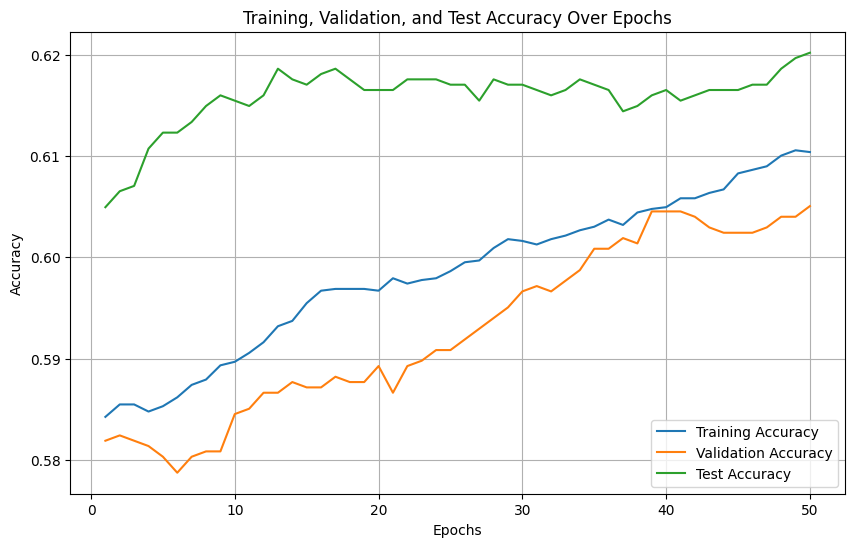

In [51]:
epoch_acc_plot(range(1, 51), train_acc_list, val_acc_list, test_acc_list)

In [ ]:
study_enhanced_feather = optuna.create_study(direction='maximize')

study_enhanced_feather.optimize(lambda trial: objectiveWithEmbedding(trial, data_TwitchDE, feather_embedding_TwitchDE, EnhancedGraphSAGE), n_trials=25)

print("最佳参数: ", study_enhanced_feather.best_params)
print("最佳测试准确率: ", study_enhanced_feather.best_value)

In [ ]:
study_enhanced_ASNE = optuna.create_study(direction='maximize')

study_enhanced_ASNE.optimize(lambda trial: objectiveWithEmbedding(trial, data_TwitchDE, ASNE_embedding_TwitchDE, EnhancedGraphSAGE), n_trials=25)

print("最佳参数: ", study_enhanced_ASNE.best_params)
print("最佳测试准确率: ", study_enhanced_ASNE.best_value)

In [ ]:
study_enhanced_BANE = optuna.create_study(direction='maximize')

study_enhanced_BANE.optimize(lambda trial: objectiveWithEmbedding(trial, data_TwitchDE, BANE_embedding_TwitchDE, EnhancedGraphSAGE), n_trials=25)

print("最佳参数: ", study_enhanced_BANE.best_params)
print("最佳测试准确率: ", study_enhanced_BANE.best_value)

##### Deezer

In [52]:
hidden_channels = 64
num_features = num_features_DeezerEurope
num_classes = get_num_classes(data_DeezerEurope) # please write down the number of classes

feather_enhanced_deezer = EnhancedGraphSAGE(num_features, hidden_channels, num_classes, feather_embedding_DeezerEurope)
optimizer = optim.Adam(feather_enhanced_deezer.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

In [53]:
print(feather_enhanced_deezer)

EnhancedGraphSAGE(
  (SAGEconv1): SAGEConv(4128, 64, aggr=mean)
  (SAGEconv2): SAGEConv(64, 2, aggr=mean)
  (act): ReLU()
)


In [54]:
node_feature_D = data_DeezerEurope.x
torch.cat([node_feature_D, torch.tensor(BANE_embedding_DeezerEurope, dtype=torch.float)], dim=1).size()

torch.Size([28281, 144])

In [55]:
train_acc_list=[]
val_acc_list=[]
test_acc_list=[]

epochs = 50
best_val_acc = final_test_acc = 0
for epoch in range(1, epochs + 1):
    loss = trainWithEmbedding(feather_enhanced_deezer, data_DeezerEurope, optimizer, loss_fn, feather_embedding_DeezerEurope)
    #print(loss)
    train_acc, val_acc, test_acc = testWithEmbedding(feather_enhanced_deezer, data_DeezerEurope, feather_embedding_DeezerEurope)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    test_acc_list.append(test_acc)
    #print(train_acc, val_acc, test_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        final_test_acc = test_acc
len_test_list = len(test_acc_list)
mean_value = np.mean(test_acc_list)
std_error = np.std(test_acc_list) / np.sqrt(len_test_list)
print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))
print("after {} epochs' training, the mean test accuracy is {}".format(epochs, mean_value))
print("after {} epochs' training, the standard error of accuracy is {}".format(epochs, std_error))

after 50 epochs' training, the best test accuracy is 0.5863531827926636
after 50 epochs' training, the mean test accuracy is 0.5690083503723145
after 50 epochs' training, the standard error of accuracy is 0.0017555359638702875


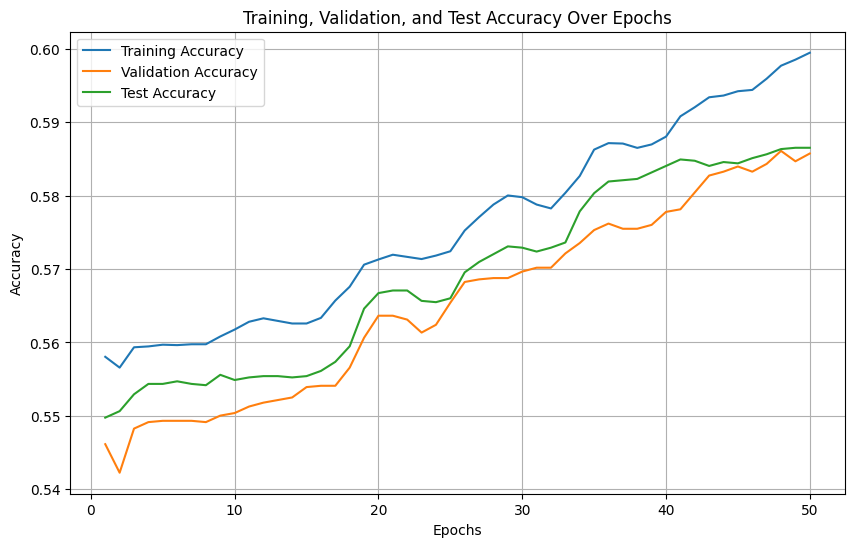

In [56]:
epoch_acc_plot(range(1, 51), train_acc_list, val_acc_list, test_acc_list)

In [57]:
hidden_channels = 64
num_features = num_features_DeezerEurope
num_classes = get_num_classes(data_DeezerEurope) # please write down the number of classes

ASNE_enhanced_deezer = EnhancedGraphSAGE(num_features, hidden_channels, num_classes, ASNE_embedding_DeezerEurope)
optimizer = optim.Adam(ASNE_enhanced_deezer.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
train_acc_list=[]
val_acc_list=[]
test_acc_list=[]

epochs = 50
best_val_acc = final_test_acc = 0
for epoch in range(1, epochs + 1):
    loss = trainWithEmbedding(ASNE_enhanced_deezer, data_DeezerEurope, optimizer, loss_fn, ASNE_embedding_DeezerEurope)
    #print(loss)
    train_acc, val_acc, test_acc = testWithEmbedding(ASNE_enhanced_deezer, data_DeezerEurope, ASNE_embedding_DeezerEurope)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    test_acc_list.append(test_acc)
    #print(train_acc, val_acc, test_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        final_test_acc = test_acc
len_test_list = len(test_acc_list)
mean_value = np.mean(test_acc_list)
std_error = np.std(test_acc_list) / np.sqrt(len_test_list)
print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))
print("after {} epochs' training, the mean test accuracy is {}".format(epochs, mean_value))
print("after {} epochs' training, the standard error of accuracy is {}".format(epochs, std_error))

after 50 epochs' training, the best test accuracy is 0.5566554665565491
after 50 epochs' training, the mean test accuracy is 0.5477815270423889
after 50 epochs' training, the standard error of accuracy is 0.0008023039179674864


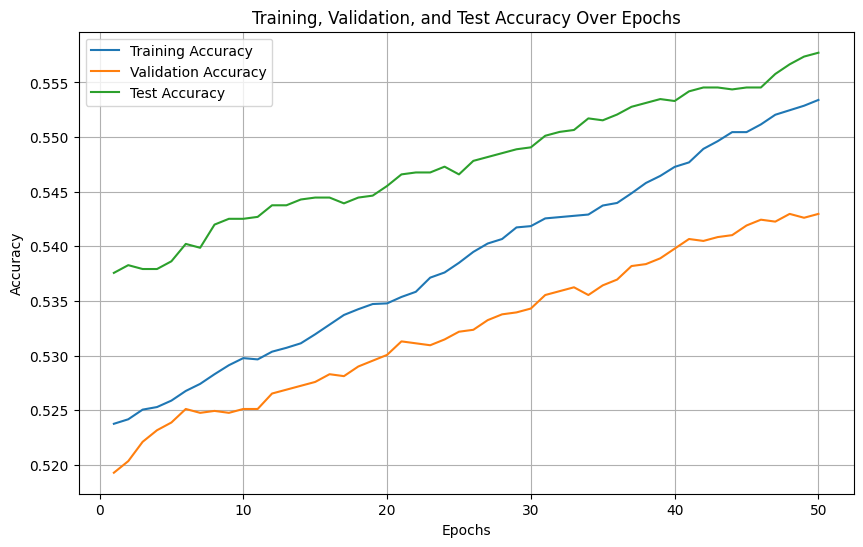

In [58]:
epoch_acc_plot(range(1, 51), train_acc_list, val_acc_list, test_acc_list)

In [59]:
hidden_channels = 64
num_features = num_features_DeezerEurope
num_classes = get_num_classes(data_DeezerEurope) # please write down the number of classes

BANE_enhanced_deezer = EnhancedGraphSAGE(num_features, hidden_channels, num_classes, BANE_embedding_DeezerEurope)
optimizer = optim.Adam(BANE_enhanced_deezer.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
train_acc_list=[]
val_acc_list=[]
test_acc_list=[]

epochs = 50
best_val_acc = final_test_acc = 0
for epoch in range(1, epochs + 1):
    loss = trainWithEmbedding(BANE_enhanced_deezer, data_DeezerEurope, optimizer, loss_fn, BANE_embedding_DeezerEurope)
    #print(loss)
    train_acc, val_acc, test_acc = testWithEmbedding(BANE_enhanced_deezer, data_DeezerEurope, BANE_embedding_DeezerEurope)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    test_acc_list.append(test_acc)
    #print(train_acc, val_acc, test_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        final_test_acc = test_acc
len_test_list = len(test_acc_list)
mean_value = np.mean(test_acc_list)
std_error = np.std(test_acc_list) / np.sqrt(len_test_list)
print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))
print("after {} epochs' training, the mean test accuracy is {}".format(epochs, mean_value))
print("after {} epochs' training, the standard error of accuracy is {}".format(epochs, std_error))

after 50 epochs' training, the best test accuracy is 0.5577161312103271
after 50 epochs' training, the mean test accuracy is 0.5445324778556824
after 50 epochs' training, the standard error of accuracy is 0.001169350877626792


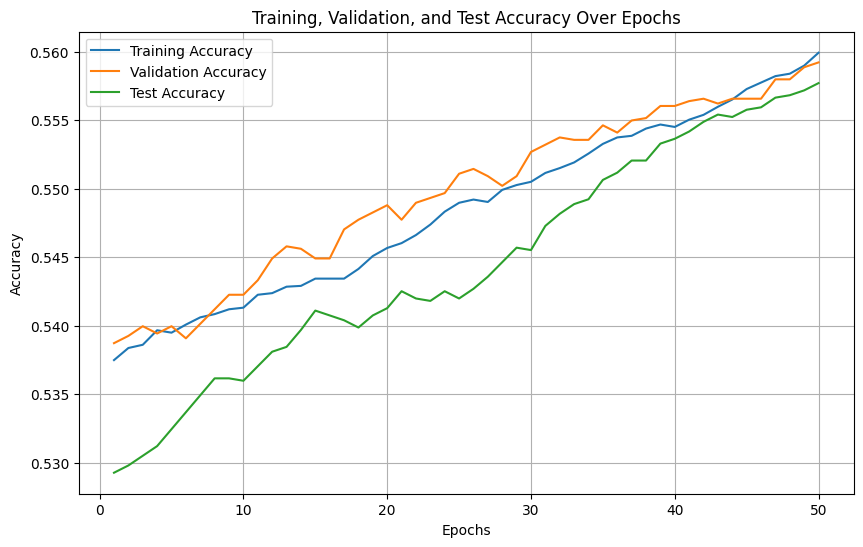

In [60]:
epoch_acc_plot(range(1, 51), train_acc_list, val_acc_list, test_acc_list)

In [ ]:
study_enhanced_feather = optuna.create_study(direction='maximize')

study_enhanced_feather.optimize(lambda trial: objectiveWithEmbedding(trial, data_DeezerEurope, feather_enhanced_deezer, EnhancedGraphSAGE), n_trials=25)

print("最佳参数: ", study_enhanced_feather.best_params)
print("最佳测试准确率: ", study_enhanced_feather.best_value)

In [ ]:
study_enhanced_ASNE = optuna.create_study(direction='maximize')

study_enhanced_ASNE.optimize(lambda trial: objectiveWithEmbedding(trial, data_DeezerEurope, ASNE_enhanced_deezer, EnhancedGraphSAGE), n_trials=25)

print("最佳参数: ", study_enhanced_ASNE.best_params)
print("最佳测试准确率: ", study_enhanced_ASNE.best_value)

In [ ]:
study_enhanced_BANE = optuna.create_study(direction='maximize')

study_enhanced_BANE.optimize(lambda trial: objectiveWithEmbedding(trial, data_DeezerEurope, BANE_enhanced_deezer, EnhancedGraphSAGE), n_trials=25)

print("最佳参数: ", study_enhanced_BANE.best_params)
print("最佳测试准确率: ", study_enhanced_BANE.best_value)

#### Between

In [61]:
class BetweenGraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, Attributed_node_embedding):
        super().__init__()
        self.SAGEconv1 = SAGEConv(in_channels, hidden_channels)
        self.SAGEconv2 = SAGEConv(hidden_channels+ Attributed_node_embedding.shape[1], out_channels)
        self.act = torch.nn.ReLU()

    def forward(self,node_feature, edge_index, Attributed_node_embedding):
        output = self.SAGEconv1(node_feature, edge_index)
        output = torch.cat([output, torch.tensor(Attributed_node_embedding, dtype=torch.float)], dim=1)
        output = self.act(output)
        output = self.SAGEconv2(output, edge_index)

        return output

##### Twitch

In [62]:
import torch.optim as optim
import torch.nn as nn

hidden_channels = 64
num_features = num_features_TwitchDE
num_classes = get_num_classes(data_TwitchDE) # please write down the number of classes

feather_between_twitch = BetweenGraphSAGE(num_features, hidden_channels, num_classes, feather_embedding_TwitchDE)
optimizer = optim.Adam(feather_between_twitch.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
train_acc_list=[]
val_acc_list=[]
test_acc_list=[]

epochs = 50
best_val_acc = final_test_acc = 0
for epoch in range(1, epochs + 1):
    loss = trainWithEmbedding(feather_between_twitch, data_TwitchDE, optimizer, loss_fn, feather_embedding_TwitchDE)
    #print(loss)
    train_acc, val_acc, test_acc = testWithEmbedding(feather_between_twitch, data_TwitchDE, feather_embedding_TwitchDE)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    test_acc_list.append(test_acc)
    #print(train_acc, val_acc, test_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        final_test_acc = test_acc
len_test_list = len(test_acc_list)
mean_value = np.mean(test_acc_list)
std_error = np.std(test_acc_list) / np.sqrt(len_test_list)
print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))
print("after {} epochs' training, the mean test accuracy is {}".format(epochs, mean_value))
print("after {} epochs' training, the standard error of accuracy is {}".format(epochs, std_error))

after 50 epochs' training, the best test accuracy is 0.6102051734924316
after 50 epochs' training, the mean test accuracy is 0.6072067022323608
after 50 epochs' training, the standard error of accuracy is 0.00017367251009809168


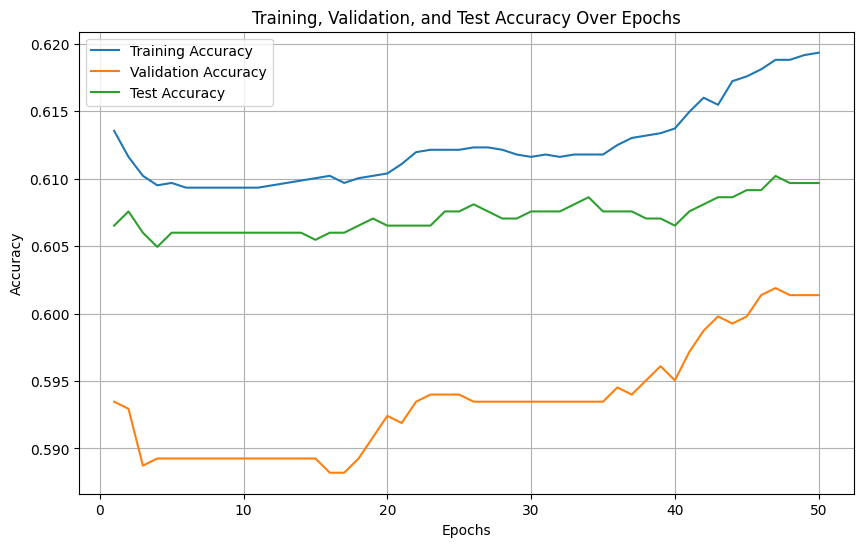

In [63]:
epoch_acc_plot(range(1, 51), train_acc_list, val_acc_list, test_acc_list)

In [64]:
hidden_channels = 64
num_features = num_features_TwitchDE
num_classes = get_num_classes(data_TwitchDE) # please write down the number of classes

ASNE_between_twitch = BetweenGraphSAGE(num_features, hidden_channels, num_classes, ASNE_embedding_TwitchDE)
optimizer = optim.Adam(ASNE_between_twitch.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
train_acc_list=[]
val_acc_list=[]
test_acc_list=[]

epochs = 50
best_val_acc = final_test_acc = 0
for epoch in range(1, epochs + 1):
    loss = trainWithEmbedding(ASNE_between_twitch, data_TwitchDE, optimizer, loss_fn, ASNE_embedding_TwitchDE)
    #print(loss)
    train_acc, val_acc, test_acc = testWithEmbedding(ASNE_between_twitch, data_TwitchDE, ASNE_embedding_TwitchDE)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    test_acc_list.append(test_acc)
    #print(train_acc, val_acc, test_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        final_test_acc = test_acc
len_test_list = len(test_acc_list)
mean_value = np.mean(test_acc_list)
std_error = np.std(test_acc_list) / np.sqrt(len_test_list)
print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))
print("after {} epochs' training, the mean test accuracy is {}".format(epochs, mean_value))
print("after {} epochs' training, the standard error of accuracy is {}".format(epochs, std_error))

after 50 epochs' training, the best test accuracy is 0.46396633982658386
after 50 epochs' training, the mean test accuracy is 0.43811678886413574
after 50 epochs' training, the standard error of accuracy is 0.002225636512095834


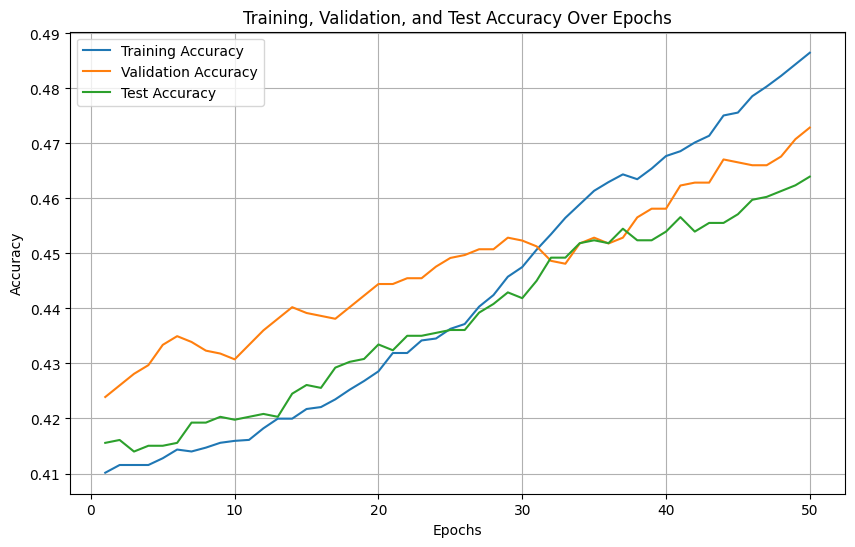

In [65]:
epoch_acc_plot(range(1, 51), train_acc_list, val_acc_list, test_acc_list)

In [66]:
hidden_channels = 64
num_features = num_features_TwitchDE
num_classes = get_num_classes(data_TwitchDE) # please write down the number of classes

BANE_between_twitch = BetweenGraphSAGE(num_features, hidden_channels, num_classes, BANE_embedding_TwitchDE)
optimizer = optim.Adam(BANE_between_twitch.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
train_acc_list=[]
val_acc_list=[]
test_acc_list=[]

epochs = 50
best_val_acc = final_test_acc = 0
for epoch in range(1, epochs + 1):
    loss = trainWithEmbedding(BANE_between_twitch, data_TwitchDE, optimizer, loss_fn, BANE_embedding_TwitchDE)
    #print(loss)
    train_acc, val_acc, test_acc = testWithEmbedding(BANE_between_twitch, data_TwitchDE, BANE_embedding_TwitchDE)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    test_acc_list.append(test_acc)
    #print(train_acc, val_acc, test_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        final_test_acc = test_acc
len_test_list = len(test_acc_list)
mean_value = np.mean(test_acc_list)
std_error = np.std(test_acc_list) / np.sqrt(len_test_list)
print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))
print("after {} epochs' training, the mean test accuracy is {}".format(epochs, mean_value))
print("after {} epochs' training, the standard error of accuracy is {}".format(epochs, std_error))

after 50 epochs' training, the best test accuracy is 0.4750131368637085
after 50 epochs' training, the mean test accuracy is 0.4599683880805969
after 50 epochs' training, the standard error of accuracy is 0.0016853617245174523


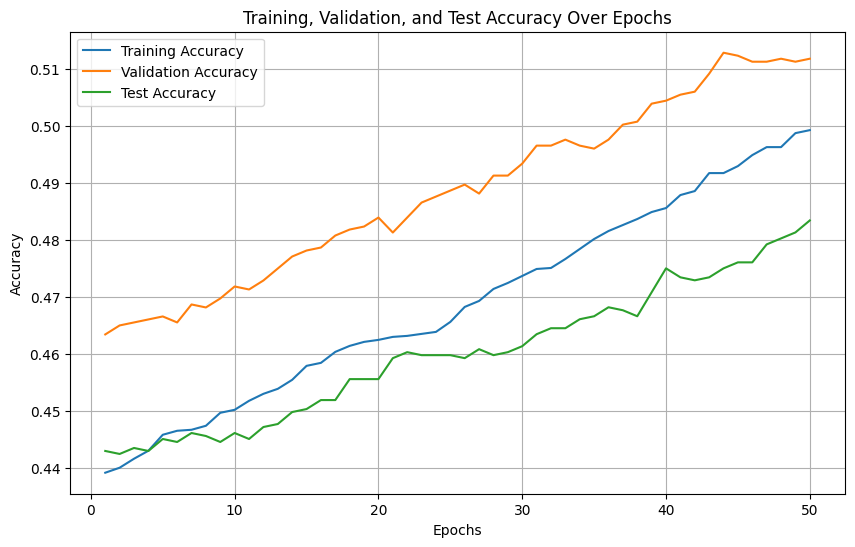

In [67]:
epoch_acc_plot(range(1, 51), train_acc_list, val_acc_list, test_acc_list)

In [ ]:
study_between_feather = optuna.create_study(direction='maximize')

study_between_feather.optimize(lambda trial: objectiveWithEmbedding(trial, data_TwitchDE, feather_embedding_TwitchDE, BetweenGraphSAGE), n_trials=25)

print("最佳参数: ", study_between_feather.best_params)
print("最佳测试准确率: ", study_between_feather.best_value)

In [ ]:
study_between_ASNE = optuna.create_study(direction='maximize')

study_between_ASNE.optimize(lambda trial: objectiveWithEmbedding(trial, data_TwitchDE, ASNE_embedding_TwitchDE, BetweenGraphSAGE), n_trials=25)

print("最佳参数: ", study_between_ASNE.best_params)
print("最佳测试准确率: ", study_between_ASNE.best_value)

In [ ]:
study_between_BANE = optuna.create_study(direction='maximize')

study_between_BANE.optimize(lambda trial: objectiveWithEmbedding(trial, data_TwitchDE, BANE_embedding_TwitchDE, BetweenGraphSAGE), n_trials=25)

print("最佳参数: ", study_between_BANE.best_params)
print("最佳测试准确率: ", study_between_BANE.best_value)

##### Deezer

In [68]:
hidden_channels = 64
num_features = num_features_DeezerEurope
num_classes = get_num_classes(data_DeezerEurope) # please write down the number of classes

feather_between_deezer = BetweenGraphSAGE(num_features, hidden_channels, num_classes, feather_embedding_DeezerEurope)
optimizer = optim.Adam(feather_between_deezer.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
train_acc_list=[]
val_acc_list=[]
test_acc_list=[]

epochs = 50
best_val_acc = final_test_acc = 0
for epoch in range(1, epochs + 1):
    loss = trainWithEmbedding(feather_between_deezer, data_DeezerEurope, optimizer, loss_fn, feather_embedding_DeezerEurope)
    #print(loss)
    train_acc, val_acc, test_acc = testWithEmbedding(feather_between_deezer, data_DeezerEurope, feather_embedding_DeezerEurope)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    test_acc_list.append(test_acc)
    #print(train_acc, val_acc, test_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        final_test_acc = test_acc
len_test_list = len(test_acc_list)
mean_value = np.mean(test_acc_list)
std_error = np.std(test_acc_list) / np.sqrt(len_test_list)
print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))
print("after {} epochs' training, the mean test accuracy is {}".format(epochs, mean_value))
print("after {} epochs' training, the standard error of accuracy is {}".format(epochs, std_error))

after 50 epochs' training, the best test accuracy is 0.5508220195770264
after 50 epochs' training, the mean test accuracy is 0.5532861948013306
after 50 epochs' training, the standard error of accuracy is 0.0009697225272182949


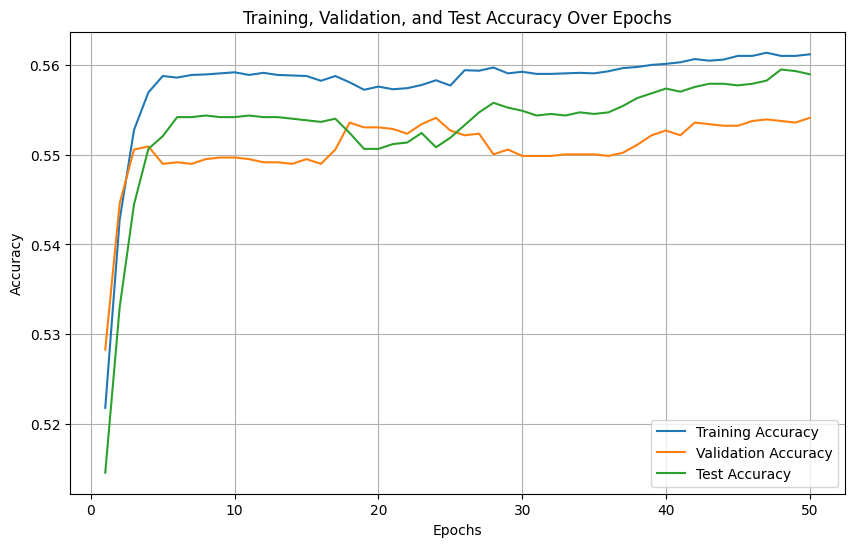

In [69]:
epoch_acc_plot(range(1, 51), train_acc_list, val_acc_list, test_acc_list)

In [70]:
hidden_channels = 64
num_features = num_features_DeezerEurope
num_classes = get_num_classes(data_DeezerEurope) # please write down the number of classes

ASNE_between_deezer = BetweenGraphSAGE(num_features, hidden_channels, num_classes, ASNE_embedding_DeezerEurope)
optimizer = optim.Adam(ASNE_between_deezer.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
train_acc_list=[]
val_acc_list=[]
test_acc_list=[]

epochs = 50
best_val_acc = final_test_acc = 0
for epoch in range(1, epochs + 1):
    loss = trainWithEmbedding(ASNE_between_deezer, data_DeezerEurope, optimizer, loss_fn, ASNE_embedding_DeezerEurope)
    #print(loss)
    train_acc, val_acc, test_acc = testWithEmbedding(ASNE_between_deezer, data_DeezerEurope, ASNE_embedding_DeezerEurope)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    test_acc_list.append(test_acc)
    #print(train_acc, val_acc, test_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        final_test_acc = test_acc
len_test_list = len(test_acc_list)
mean_value = np.mean(test_acc_list)
std_error = np.std(test_acc_list) / np.sqrt(len_test_list)
print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))
print("after {} epochs' training, the mean test accuracy is {}".format(epochs, mean_value))
print("after {} epochs' training, the standard error of accuracy is {}".format(epochs, std_error))

after 50 epochs' training, the best test accuracy is 0.5663779377937317
after 50 epochs' training, the mean test accuracy is 0.5558034181594849
after 50 epochs' training, the standard error of accuracy is 0.0011427496307713381


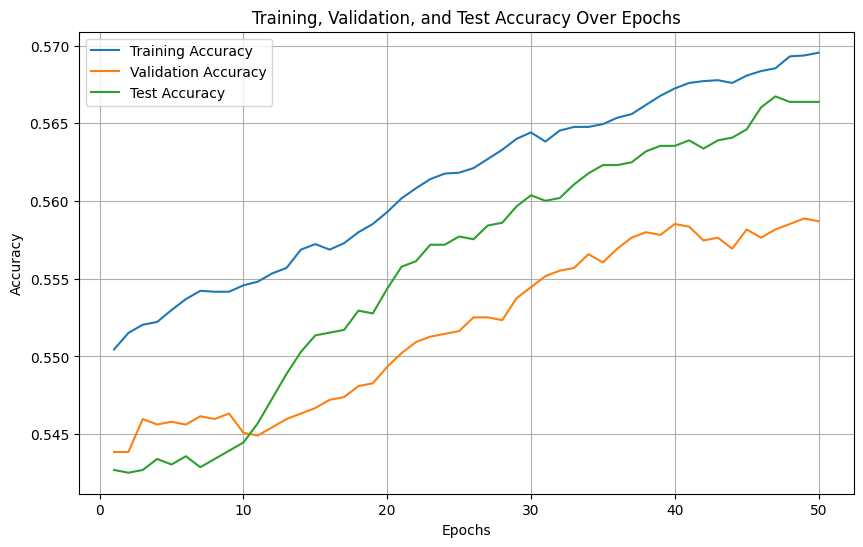

In [71]:
epoch_acc_plot(range(1, 51), train_acc_list, val_acc_list, test_acc_list)

In [72]:
hidden_channels = 64
num_features = num_features_DeezerEurope
num_classes = get_num_classes(data_DeezerEurope) # please write down the number of classes

BANE_between_deezer = BetweenGraphSAGE(num_features, hidden_channels, num_classes, BANE_embedding_DeezerEurope)
optimizer = optim.Adam(BANE_between_deezer.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
train_acc_list=[]
val_acc_list=[]
test_acc_list=[]

epochs = 50
best_val_acc = final_test_acc = 0
for epoch in range(1, epochs + 1):
    loss = trainWithEmbedding(BANE_between_deezer, data_DeezerEurope, optimizer, loss_fn, BANE_embedding_DeezerEurope)
    #print(loss)
    train_acc, val_acc, test_acc = testWithEmbedding(BANE_between_deezer, data_DeezerEurope, BANE_embedding_DeezerEurope)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    test_acc_list.append(test_acc)
    #print(train_acc, val_acc, test_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        final_test_acc = test_acc
len_test_list = len(test_acc_list)
mean_value = np.mean(test_acc_list)
std_error = np.std(test_acc_list) / np.sqrt(len_test_list)
print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))
print("after {} epochs' training, the mean test accuracy is {}".format(epochs, mean_value))
print("after {} epochs' training, the standard error of accuracy is {}".format(epochs, std_error))

after 50 epochs' training, the best test accuracy is 0.4774615466594696
after 50 epochs' training, the mean test accuracy is 0.47091034054756165
after 50 epochs' training, the standard error of accuracy is 0.000499547300045543


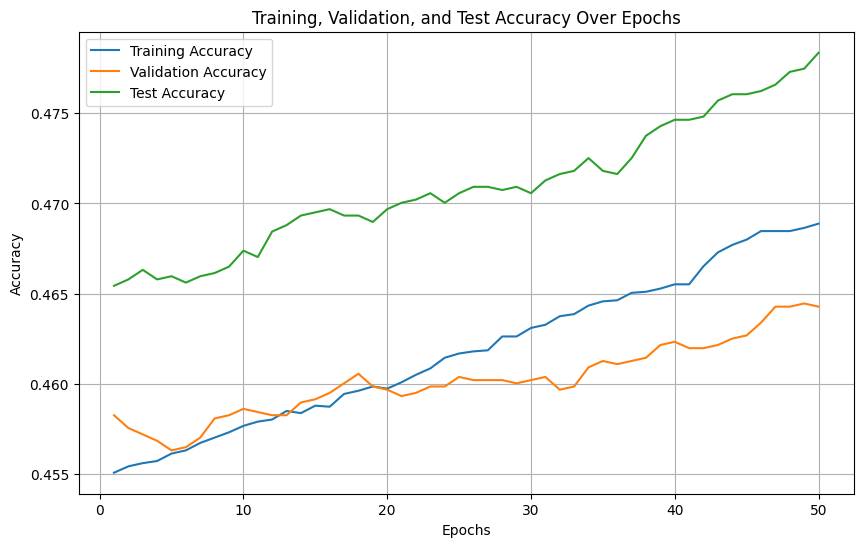

In [73]:
epoch_acc_plot(range(1, 51), train_acc_list, val_acc_list, test_acc_list)

In [ ]:
study_between_feather = optuna.create_study(direction='maximize')

study_between_feather.optimize(lambda trial: objectiveWithEmbedding(trial, data_DeezerEurope, feather_embedding_DeezerEurope, BetweenGraphSAGE), n_trials=25)

print("最佳参数: ", study_between_feather.best_params)
print("最佳测试准确率: ", study_between_feather.best_value)

In [ ]:
study_between_ASNE = optuna.create_study(direction='maximize')

study_between_ASNE.optimize(lambda trial: objectiveWithEmbedding(trial, data_DeezerEurope, ASNE_embedding_DeezerEurope, BetweenGraphSAGE), n_trials=25)

print("最佳参数: ", study_between_ASNE.best_params)
print("最佳测试准确率: ", study_between_ASNE.best_value)

In [ ]:
study_between_BANE = optuna.create_study(direction='maximize')

study_between_BANE.optimize(lambda trial: objectiveWithEmbedding(trial, data_DeezerEurope, BANE_embedding_DeezerEurope, BetweenGraphSAGE), n_trials=25)

print("最佳参数: ", study_between_BANE.best_params)
print("最佳测试准确率: ", study_between_BANE.best_value)

#### After(可能需要更改)

In [74]:
class AfterGraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, Attributed_node_embedding):
        super().__init__()
        self.SAGEconv1 = SAGEConv(in_channels, hidden_channels)
        self.SAGEconv2 = SAGEConv(hidden_channels, hidden_channels)
        self.act = torch.nn.ReLU()
        self.fc = torch.nn.Linear(hidden_channels+Attributed_node_embedding.shape[1], out_channels)

    def forward(self,node_feature, edge_index, Attributed_node_embedding):
        output = self.SAGEconv1(node_feature, edge_index)
        output = self.act(output)
        output = self.SAGEconv2(output, edge_index)
        output = self.act(output)
        output = torch.cat([output, torch.tensor(Attributed_node_embedding, dtype=torch.float)], dim=1)
        output = self.fc(output)
        # 这里可能需要更改为
        # output = self.act(output)
        # output = torch.cat([output, torch.tensor(Attributed_node_embedding, dtype=torch.float)], dim=1)
        # output = self.fc(output)
        # output = self.act(output)

        return output

##### Twitch

In [75]:
import torch.optim as optim
import torch.nn as nn

hidden_channels = 64
num_features = num_features_TwitchDE
num_classes = get_num_classes(data_TwitchDE) # please write down the number of classes

feather_after_twitch = AfterGraphSAGE(num_features, hidden_channels, num_classes, feather_embedding_TwitchDE)
optimizer = optim.Adam(feather_after_twitch.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
train_acc_list=[]
val_acc_list=[]
test_acc_list=[]

epochs = 50
best_val_acc = final_test_acc = 0
for epoch in range(1, epochs + 1):
    loss = trainWithEmbedding(feather_after_twitch, data_TwitchDE, optimizer, loss_fn, feather_embedding_TwitchDE)
    #print(loss)
    train_acc, val_acc, test_acc = testWithEmbedding(feather_after_twitch, data_TwitchDE, feather_embedding_TwitchDE)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    test_acc_list.append(test_acc)
    #print(train_acc, val_acc, test_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        final_test_acc = test_acc
len_test_list = len(test_acc_list)
mean_value = np.mean(test_acc_list)
std_error = np.std(test_acc_list) / np.sqrt(len_test_list)
print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))
print("after {} epochs' training, the mean test accuracy is {}".format(epochs, mean_value))
print("after {} epochs' training, the standard error of accuracy is {}".format(epochs, std_error))

after 50 epochs' training, the best test accuracy is 0.6091530919075012
after 50 epochs' training, the mean test accuracy is 0.6067753434181213
after 50 epochs' training, the standard error of accuracy is 0.00016382687457704525


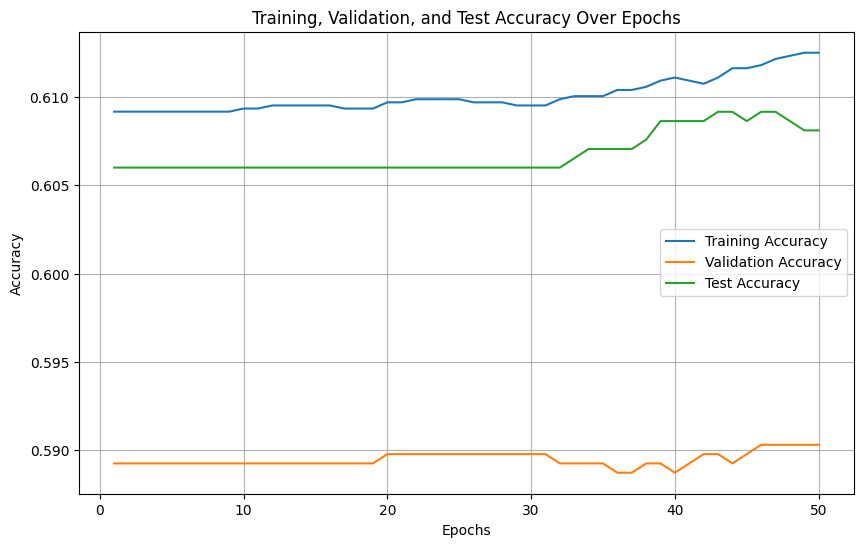

In [76]:
epoch_acc_plot(range(1, 51), train_acc_list, val_acc_list, test_acc_list)

In [77]:
hidden_channels = 64
num_features = num_features_TwitchDE
num_classes = get_num_classes(data_TwitchDE) # please write down the number of classes

ASNE_after_twitch = AfterGraphSAGE(num_features, hidden_channels, num_classes, ASNE_embedding_TwitchDE)
optimizer = optim.Adam(ASNE_after_twitch.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
train_acc_list=[]
val_acc_list=[]
test_acc_list=[]

epochs = 50
best_val_acc = final_test_acc = 0
for epoch in range(1, epochs + 1):
    loss = trainWithEmbedding(ASNE_after_twitch, data_TwitchDE, optimizer, loss_fn, ASNE_embedding_TwitchDE)
    #print(loss)
    train_acc, val_acc, test_acc = testWithEmbedding(ASNE_after_twitch, data_TwitchDE, ASNE_embedding_TwitchDE)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    test_acc_list.append(test_acc)
    #print(train_acc, val_acc, test_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        final_test_acc = test_acc
len_test_list = len(test_acc_list)
mean_value = np.mean(test_acc_list)
std_error = np.std(test_acc_list) / np.sqrt(len_test_list)
print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))
print("after {} epochs' training, the mean test accuracy is {}".format(epochs, mean_value))
print("after {} epochs' training, the standard error of accuracy is {}".format(epochs, std_error))

after 50 epochs' training, the best test accuracy is 0.5244607925415039
after 50 epochs' training, the mean test accuracy is 0.5211572647094727
after 50 epochs' training, the standard error of accuracy is 0.001328623686440559


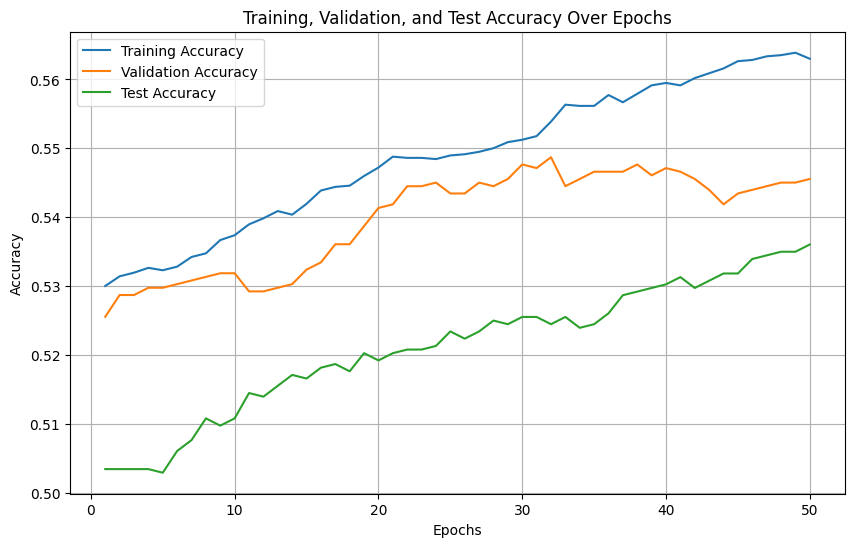

In [78]:
epoch_acc_plot(range(1, 51), train_acc_list, val_acc_list, test_acc_list)

In [79]:
hidden_channels = 64
num_features = num_features_TwitchDE
num_classes = get_num_classes(data_TwitchDE) # please write down the number of classes

BANE_after_twitch = AfterGraphSAGE(num_features, hidden_channels, num_classes, BANE_embedding_TwitchDE)
optimizer = optim.Adam(BANE_after_twitch.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
train_acc_list=[]
val_acc_list=[]
test_acc_list=[]

epochs = 50
best_val_acc = final_test_acc = 0
for epoch in range(1, epochs + 1):
    loss = trainWithEmbedding(BANE_after_twitch, data_TwitchDE, optimizer, loss_fn, BANE_embedding_TwitchDE)
    #print(loss)
    train_acc, val_acc, test_acc = testWithEmbedding(BANE_after_twitch, data_TwitchDE, BANE_embedding_TwitchDE)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    test_acc_list.append(test_acc)
    #print(train_acc, val_acc, test_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        final_test_acc = test_acc
len_test_list = len(test_acc_list)
mean_value = np.mean(test_acc_list)
std_error = np.std(test_acc_list) / np.sqrt(len_test_list)
print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))
print("after {} epochs' training, the mean test accuracy is {}".format(epochs, mean_value))
print("after {} epochs' training, the standard error of accuracy is {}".format(epochs, std_error))

after 50 epochs' training, the best test accuracy is 0.5433982014656067
after 50 epochs' training, the mean test accuracy is 0.5284903049468994
after 50 epochs' training, the standard error of accuracy is 0.0012661359785848978


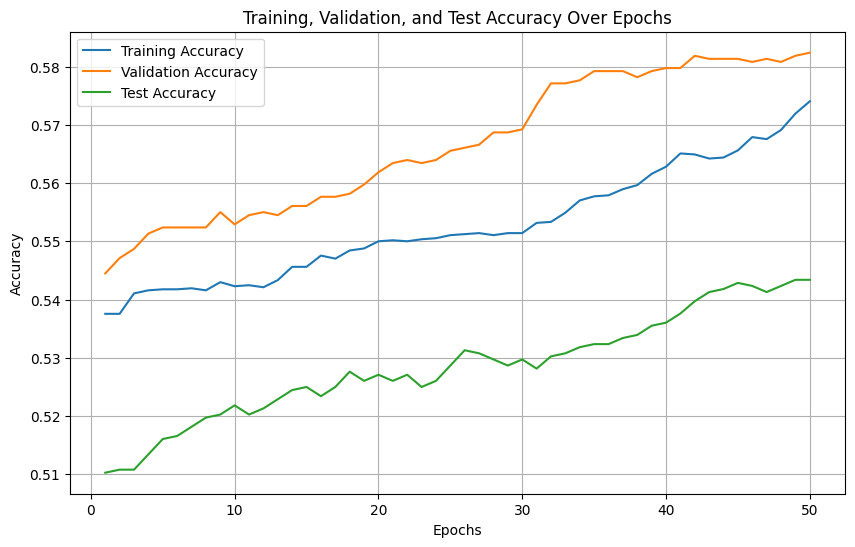

In [80]:
epoch_acc_plot(range(1, 51), train_acc_list, val_acc_list, test_acc_list)

In [ ]:
study_after_feather = optuna.create_study(direction='maximize')

study_after_feather.optimize(lambda trial: objectiveWithEmbedding(trial, data_TwitchDE, feather_embedding_TwitchDE, AfterGraphSAGE), n_trials=25)

print("最佳参数: ", study_after_feather.best_params)
print("最佳测试准确率: ", study_after_feather.best_value)

In [ ]:
study_after_ASNE = optuna.create_study(direction='maximize')

study_after_ASNE.optimize(lambda trial: objectiveWithEmbedding(trial, data_TwitchDE, ASNE_embedding_TwitchDE, AfterGraphSAGE), n_trials=25)

print("最佳参数: ", study_after_ASNE.best_params)
print("最佳测试准确率: ", study_after_ASNE.best_value)

In [ ]:
study_after_BANE = optuna.create_study(direction='maximize')

study_after_BANE.optimize(lambda trial: objectiveWithEmbedding(trial, data_TwitchDE, BANE_embedding_TwitchDE, AfterGraphSAGE), n_trials=25)

print("最佳参数: ", study_after_BANE.best_params)
print("最佳测试准确率: ", study_after_BANE.best_value)

##### Deezer

In [81]:
hidden_channels = 64
num_features = num_features_DeezerEurope
num_classes = get_num_classes(data_DeezerEurope) # please write down the number of classes

feather_after_deezer = AfterGraphSAGE(num_features, hidden_channels, num_classes, feather_embedding_DeezerEurope)
optimizer = optim.Adam(feather_after_deezer.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
train_acc_list=[]
val_acc_list=[]
test_acc_list=[]

epochs = 50
best_val_acc = final_test_acc = 0
for epoch in range(1, epochs + 1):
    loss = trainWithEmbedding(feather_after_deezer, data_DeezerEurope, optimizer, loss_fn, feather_embedding_DeezerEurope)
    #print(loss)
    train_acc, val_acc, test_acc = testWithEmbedding(feather_after_deezer, data_DeezerEurope, feather_embedding_DeezerEurope)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    test_acc_list.append(test_acc)
    #print(train_acc, val_acc, test_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        final_test_acc = test_acc
len_test_list = len(test_acc_list)
mean_value = np.mean(test_acc_list)
std_error = np.std(test_acc_list) / np.sqrt(len_test_list)
print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))
print("after {} epochs' training, the mean test accuracy is {}".format(epochs, mean_value))
print("after {} epochs' training, the standard error of accuracy is {}".format(epochs, std_error))

after 50 epochs' training, the best test accuracy is 0.5557715892791748
after 50 epochs' training, the mean test accuracy is 0.5547109842300415
after 50 epochs' training, the standard error of accuracy is 0.00014688059814396402


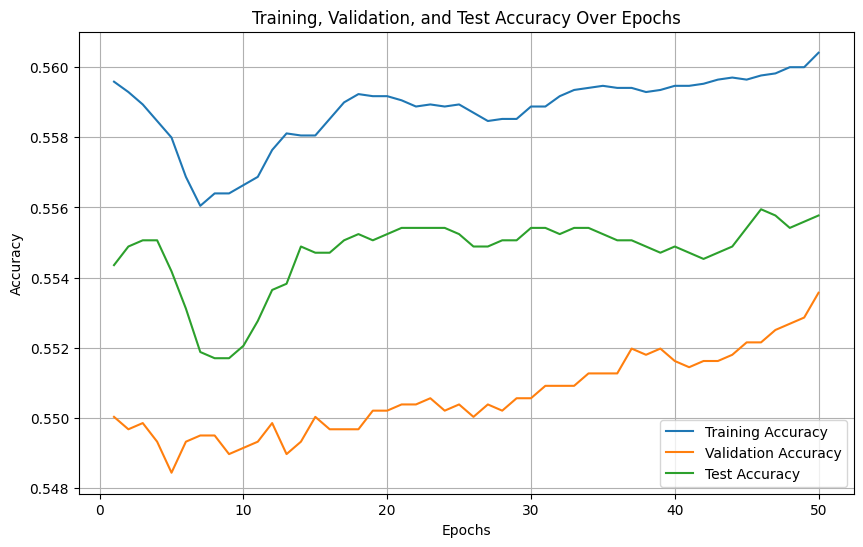

In [82]:
epoch_acc_plot(range(1, 51), train_acc_list, val_acc_list, test_acc_list)

In [83]:
hidden_channels = 64
num_features = num_features_DeezerEurope
num_classes = get_num_classes(data_DeezerEurope) # please write down the number of classes

ASNE_after_deezer = AfterGraphSAGE(num_features, hidden_channels, num_classes, ASNE_embedding_DeezerEurope)
optimizer = optim.Adam(ASNE_after_deezer.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
train_acc_list=[]
val_acc_list=[]
test_acc_list=[]

epochs = 50
best_val_acc = final_test_acc = 0
for epoch in range(1, epochs + 1):
    loss = trainWithEmbedding(ASNE_after_deezer, data_DeezerEurope, optimizer, loss_fn, ASNE_embedding_DeezerEurope)
    #print(loss)
    train_acc, val_acc, test_acc = testWithEmbedding(ASNE_after_deezer, data_DeezerEurope, ASNE_embedding_DeezerEurope)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    test_acc_list.append(test_acc)
    #print(train_acc, val_acc, test_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        final_test_acc = test_acc
len_test_list = len(test_acc_list)
mean_value = np.mean(test_acc_list)
std_error = np.std(test_acc_list) / np.sqrt(len_test_list)
print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))
print("after {} epochs' training, the mean test accuracy is {}".format(epochs, mean_value))
print("after {} epochs' training, the standard error of accuracy is {}".format(epochs, std_error))

after 50 epochs' training, the best test accuracy is 0.5257203578948975
after 50 epochs' training, the mean test accuracy is 0.5059996843338013
after 50 epochs' training, the standard error of accuracy is 0.0017224334339231266


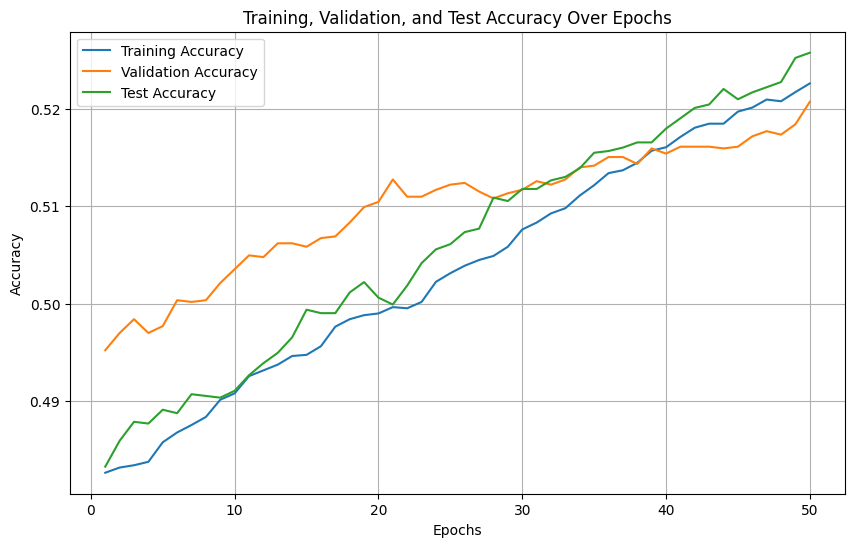

In [84]:
epoch_acc_plot(range(1, 51), train_acc_list, val_acc_list, test_acc_list)

In [85]:
hidden_channels = 64
num_features = num_features_DeezerEurope
num_classes = get_num_classes(data_DeezerEurope) # please write down the number of classes

BANE_after_deezer = AfterGraphSAGE(num_features, hidden_channels, num_classes, BANE_embedding_DeezerEurope)
optimizer = optim.Adam(BANE_after_deezer.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
train_acc_list=[]
val_acc_list=[]
test_acc_list=[]

epochs = 50
best_val_acc = final_test_acc = 0
for epoch in range(1, epochs + 1):
    loss = trainWithEmbedding(BANE_after_deezer, data_DeezerEurope, optimizer, loss_fn, BANE_embedding_DeezerEurope)
    #print(loss)
    train_acc, val_acc, test_acc = testWithEmbedding(BANE_after_deezer, data_DeezerEurope, BANE_embedding_DeezerEurope)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    test_acc_list.append(test_acc)
    #print(train_acc, val_acc, test_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        final_test_acc = test_acc
len_test_list = len(test_acc_list)
mean_value = np.mean(test_acc_list)
std_error = np.std(test_acc_list) / np.sqrt(len_test_list)
print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))
print("after {} epochs' training, the mean test accuracy is {}".format(epochs, mean_value))
print("after {} epochs' training, the standard error of accuracy is {}".format(epochs, std_error))

after 50 epochs' training, the best test accuracy is 0.5525897145271301
after 50 epochs' training, the mean test accuracy is 0.5468870401382446
after 50 epochs' training, the standard error of accuracy is 0.000448926267878702


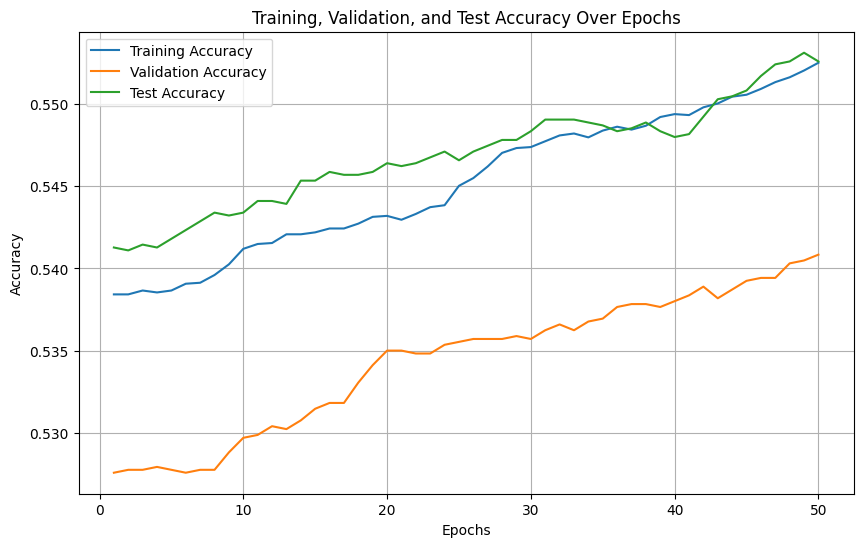

In [86]:
epoch_acc_plot(range(1, 51), train_acc_list, val_acc_list, test_acc_list)

In [ ]:
study_after_feather = optuna.create_study(direction='maximize')

study_after_feather.optimize(lambda trial: objectiveWithEmbedding(trial, data_DeezerEurope, feather_embedding_DeezerEurope, AfterGraphSAGE), n_trials=25)

print("最佳参数: ", study_after_feather.best_params)
print("最佳测试准确率: ", study_after_feather.best_value)

In [ ]:
study_after_ASNE = optuna.create_study(direction='maximize')

study_after_ASNE.optimize(lambda trial: objectiveWithEmbedding(trial, data_DeezerEurope, ASNE_embedding_DeezerEurope, AfterGraphSAGE), n_trials=25)

print("最佳参数: ", study_after_ASNE.best_params)
print("最佳测试准确率: ", study_after_ASNE.best_value)

In [ ]:
study_after_BANE = optuna.create_study(direction='maximize')

study_after_BANE.optimize(lambda trial: objectiveWithEmbedding(trial, data_DeezerEurope, BANE_embedding_DeezerEurope, AfterGraphSAGE), n_trials=25)

print("最佳参数: ", study_after_BANE.best_params)
print("最佳测试准确率: ", study_after_BANE.best_value)

#### Before

In [87]:
class BeforeGraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, Attributed_node_embedding):
        super().__init__()
        self.SAGEconv1 = SAGEConv(Attributed_node_embedding.shape[1], hidden_channels)
        self.SAGEconv2 = SAGEConv(hidden_channels, out_channels)
        self.act = torch.nn.ReLU()

    def forward(self,node_feature, edge_index, Attributed_node_embedding):
        output = self.SAGEconv1(torch.tensor(Attributed_node_embedding, dtype=torch.float), edge_index)
        output = self.act(output)
        output = self.SAGEconv2(output, edge_index)
        return output

##### Twitch

In [88]:
import torch.optim as optim
import torch.nn as nn

hidden_channels = 64
num_features = num_features_TwitchDE
num_classes = get_num_classes(data_TwitchDE) # please write down the number of classes

feather_before_twitch = BeforeGraphSAGE(num_features, hidden_channels, num_classes, feather_embedding_TwitchDE)
optimizer = optim.Adam(feather_before_twitch.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
train_acc_list=[]
val_acc_list=[]
test_acc_list=[]

epochs = 50
best_val_acc = final_test_acc = 0
for epoch in range(1, epochs + 1):
    loss = trainWithEmbedding(feather_before_twitch, data_TwitchDE, optimizer, loss_fn, feather_embedding_TwitchDE)
    #print(loss)
    train_acc, val_acc, test_acc = testWithEmbedding(feather_before_twitch, data_TwitchDE, feather_embedding_TwitchDE)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    test_acc_list.append(test_acc)
    #print(train_acc, val_acc, test_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        final_test_acc = test_acc
len_test_list = len(test_acc_list)
mean_value = np.mean(test_acc_list)
std_error = np.std(test_acc_list) / np.sqrt(len_test_list)
print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))
print("after {} epochs' training, the mean test accuracy is {}".format(epochs, mean_value))
print("after {} epochs' training, the standard error of accuracy is {}".format(epochs, std_error))

after 50 epochs' training, the best test accuracy is 0.6286165118217468
after 50 epochs' training, the mean test accuracy is 0.61297208070755
after 50 epochs' training, the standard error of accuracy is 0.0012464181023446824


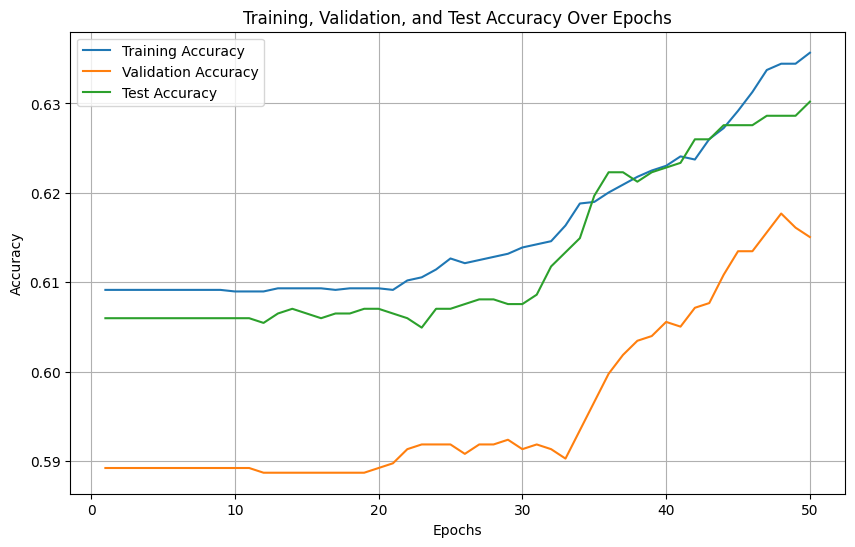

In [89]:
epoch_acc_plot(range(1, 51), train_acc_list, val_acc_list, test_acc_list)

In [90]:
hidden_channels = 64
num_features = num_features_TwitchDE
num_classes = get_num_classes(data_TwitchDE) # please write down the number of classes

ASNE_before_twitch = BeforeGraphSAGE(num_features, hidden_channels, num_classes, ASNE_embedding_TwitchDE)
optimizer = optim.Adam(ASNE_before_twitch.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
train_acc_list=[]
val_acc_list=[]
test_acc_list=[]

epochs = 50
best_val_acc = final_test_acc = 0
for epoch in range(1, epochs + 1):
    loss = trainWithEmbedding(ASNE_before_twitch, data_TwitchDE, optimizer, loss_fn, ASNE_embedding_TwitchDE)
    #print(loss)
    train_acc, val_acc, test_acc = testWithEmbedding(ASNE_before_twitch, data_TwitchDE, ASNE_embedding_TwitchDE)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    test_acc_list.append(test_acc)
    #print(train_acc, val_acc, test_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        final_test_acc = test_acc
len_test_list = len(test_acc_list)
mean_value = np.mean(test_acc_list)
std_error = np.std(test_acc_list) / np.sqrt(len_test_list)
print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))
print("after {} epochs' training, the mean test accuracy is {}".format(epochs, mean_value))
print("after {} epochs' training, the standard error of accuracy is {}".format(epochs, std_error))

after 50 epochs' training, the best test accuracy is 0.5607575178146362
after 50 epochs' training, the mean test accuracy is 0.502314567565918
after 50 epochs' training, the standard error of accuracy is 0.005234301410264952


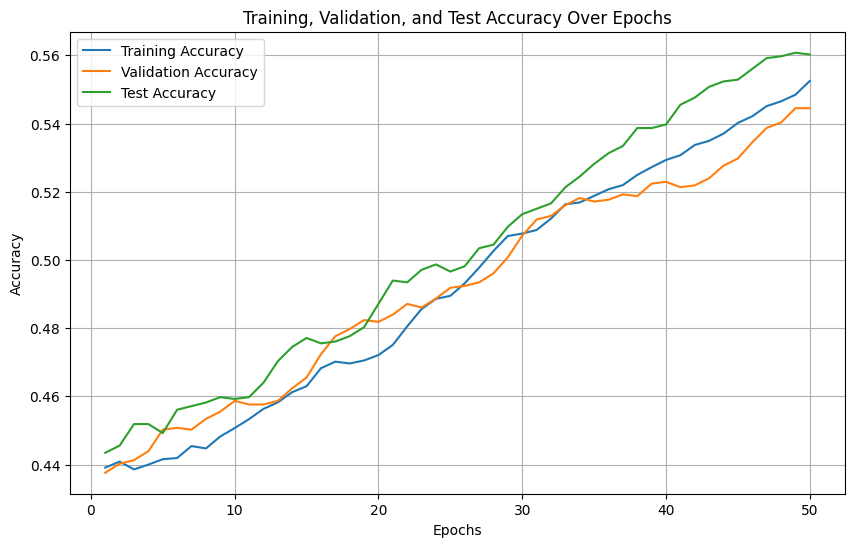

In [91]:
epoch_acc_plot(range(1, 51), train_acc_list, val_acc_list, test_acc_list)

In [92]:
hidden_channels = 64
num_features = num_features_TwitchDE
num_classes = get_num_classes(data_TwitchDE) # please write down the number of classes

BANE_before_twitch = BeforeGraphSAGE(num_features, hidden_channels, num_classes, BANE_embedding_TwitchDE)
optimizer = optim.Adam(BANE_before_twitch.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
train_acc_list=[]
val_acc_list=[]
test_acc_list=[]

epochs = 50
best_val_acc = final_test_acc = 0
for epoch in range(1, epochs + 1):
    loss = trainWithEmbedding(BANE_before_twitch, data_TwitchDE, optimizer, loss_fn, BANE_embedding_TwitchDE)
    #print(loss)
    train_acc, val_acc, test_acc = testWithEmbedding(BANE_before_twitch, data_TwitchDE, BANE_embedding_TwitchDE)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    test_acc_list.append(test_acc)
    #print(train_acc, val_acc, test_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        final_test_acc = test_acc
len_test_list = len(test_acc_list)
mean_value = np.mean(test_acc_list)
std_error = np.std(test_acc_list) / np.sqrt(len_test_list)
print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))
print("after {} epochs' training, the mean test accuracy is {}".format(epochs, mean_value))
print("after {} epochs' training, the standard error of accuracy is {}".format(epochs, std_error))

after 50 epochs' training, the best test accuracy is 0.5960021018981934
after 50 epochs' training, the mean test accuracy is 0.6002735495567322
after 50 epochs' training, the standard error of accuracy is 0.0002989234937587792


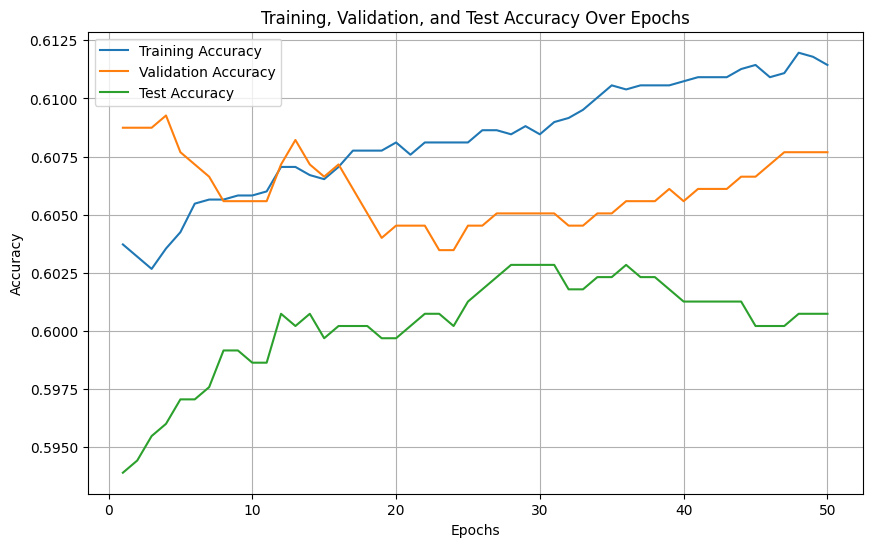

In [93]:
epoch_acc_plot(range(1, 51), train_acc_list, val_acc_list, test_acc_list)

In [ ]:
study_before_feather = optuna.create_study(direction='maximize')

study_before_feather.optimize(lambda trial: objectiveWithEmbedding(trial, data_TwitchDE, feather_embedding_TwitchDE, BeforeGraphSAGE), n_trials=25)

print("最佳参数: ", study_before_feather.best_params)
print("最佳测试准确率: ", study_before_feather.best_value)

In [ ]:
study_before_ASNE = optuna.create_study(direction='maximize')

study_before_ASNE.optimize(lambda trial: objectiveWithEmbedding(trial, data_TwitchDE, ASNE_embedding_TwitchDE, BeforeGraphSAGE), n_trials=25)

print("最佳参数: ", study_before_ASNE.best_params)
print("最佳测试准确率: ", study_before_ASNE.best_value)

In [ ]:
study_before_BANE = optuna.create_study(direction='maximize')

study_before_BANE.optimize(lambda trial: objectiveWithEmbedding(trial, data_TwitchDE, BANE_embedding_TwitchDE, BeforeGraphSAGE), n_trials=25)

print("最佳参数: ", study_before_BANE.best_params)
print("最佳测试准确率: ", study_before_BANE.best_value)

##### Deezer

In [94]:
hidden_channels = 64
num_features = num_features_DeezerEurope
num_classes = get_num_classes(data_DeezerEurope) # please write down the number of classes

feather_before_deezer = BeforeGraphSAGE(num_features, hidden_channels, num_classes, feather_embedding_DeezerEurope)
optimizer = optim.Adam(feather_before_deezer.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
train_acc_list=[]
val_acc_list=[]
test_acc_list=[]

epochs = 50
best_val_acc = final_test_acc = 0
for epoch in range(1, epochs + 1):
    loss = trainWithEmbedding(feather_before_deezer, data_DeezerEurope, optimizer, loss_fn, feather_embedding_DeezerEurope)
    #print(loss)
    train_acc, val_acc, test_acc = testWithEmbedding(feather_before_deezer, data_DeezerEurope, feather_embedding_DeezerEurope)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    test_acc_list.append(test_acc)
    #print(train_acc, val_acc, test_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        final_test_acc = test_acc
len_test_list = len(test_acc_list)
mean_value = np.mean(test_acc_list)
std_error = np.std(test_acc_list) / np.sqrt(len_test_list)
print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))
print("after {} epochs' training, the mean test accuracy is {}".format(epochs, mean_value))
print("after {} epochs' training, the standard error of accuracy is {}".format(epochs, std_error))

after 50 epochs' training, the best test accuracy is 0.5727417469024658
after 50 epochs' training, the mean test accuracy is 0.5613399147987366
after 50 epochs' training, the standard error of accuracy is 0.001426963610982012


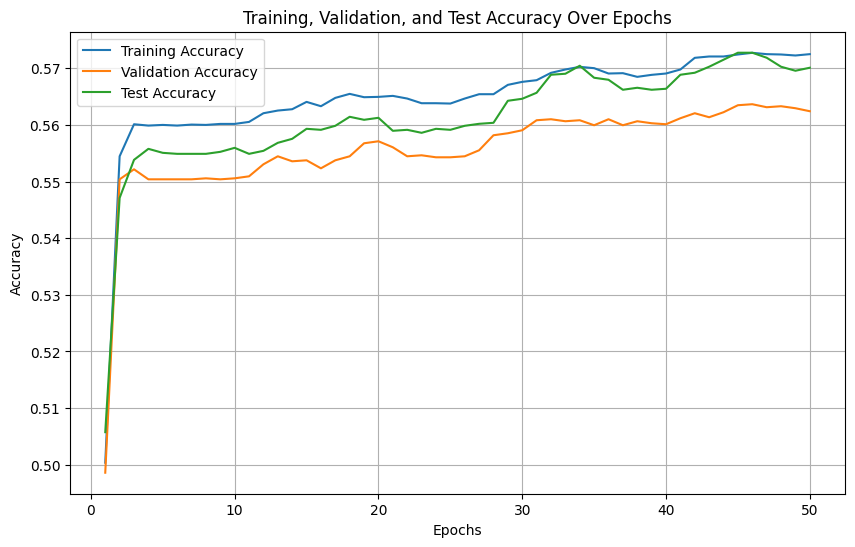

In [95]:
epoch_acc_plot(range(1, 51), train_acc_list, val_acc_list, test_acc_list)

In [96]:
hidden_channels = 64
num_features = num_features_DeezerEurope
#num_features_DeezerEurope
num_classes = get_num_classes(data_DeezerEurope) # please write down the number of classes

ASNE_before_deezer = BeforeGraphSAGE(num_features, hidden_channels, num_classes, ASNE_embedding_DeezerEurope)
optimizer = optim.Adam(ASNE_before_deezer.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
train_acc_list=[]
val_acc_list=[]
test_acc_list=[]

epochs = 50
best_val_acc = final_test_acc = 0
for epoch in range(1, epochs + 1):
    loss = trainWithEmbedding(ASNE_before_deezer, data_DeezerEurope, optimizer, loss_fn, ASNE_embedding_DeezerEurope)
    #print(loss)
    train_acc, val_acc, test_acc = testWithEmbedding(ASNE_before_deezer, data_DeezerEurope, ASNE_embedding_DeezerEurope)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    test_acc_list.append(test_acc)
    #print(train_acc, val_acc, test_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        final_test_acc = test_acc
len_test_list = len(test_acc_list)
mean_value = np.mean(test_acc_list)
std_error = np.std(test_acc_list) / np.sqrt(len_test_list)
print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))
print("after {} epochs' training, the mean test accuracy is {}".format(epochs, mean_value))
print("after {} epochs' training, the standard error of accuracy is {}".format(epochs, std_error))

after 50 epochs' training, the best test accuracy is 0.5331447720527649
after 50 epochs' training, the mean test accuracy is 0.5129503011703491
after 50 epochs' training, the standard error of accuracy is 0.0018981446990362567


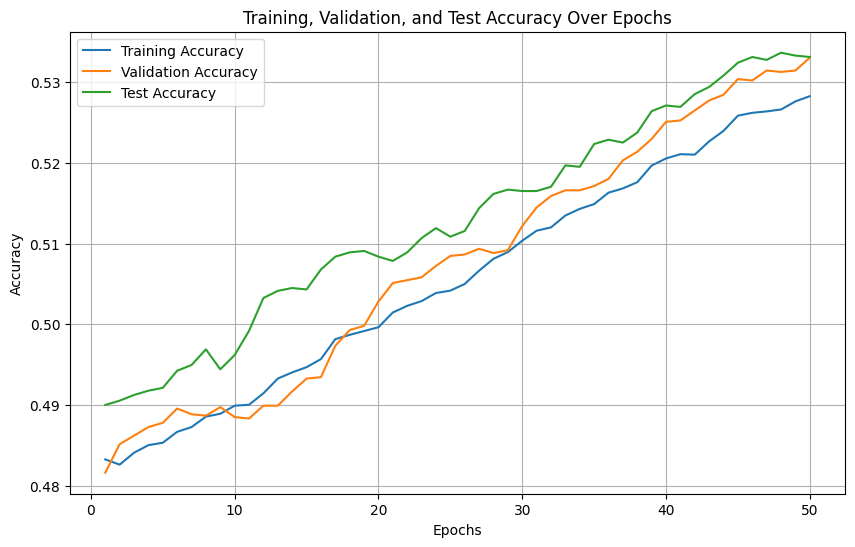

In [97]:
epoch_acc_plot(range(1, 51), train_acc_list, val_acc_list, test_acc_list)

In [98]:
hidden_channels = 64
num_features = num_features_DeezerEurope
num_classes = get_num_classes(data_DeezerEurope) # please write down the number of classes

BANE_before_deezer = BeforeGraphSAGE(num_features, hidden_channels, num_classes, BANE_embedding_DeezerEurope)
optimizer = optim.Adam(BANE_before_deezer.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
train_acc_list=[]
val_acc_list=[]
test_acc_list=[]

epochs = 50
best_val_acc = final_test_acc = 0
for epoch in range(1, epochs + 1):
    loss = trainWithEmbedding(BANE_before_deezer, data_DeezerEurope, optimizer, loss_fn, BANE_embedding_DeezerEurope)
    #print(loss)
    train_acc, val_acc, test_acc = testWithEmbedding(BANE_before_deezer, data_DeezerEurope, BANE_embedding_DeezerEurope)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    test_acc_list.append(test_acc)
    #print(train_acc, val_acc, test_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        final_test_acc = test_acc
len_test_list = len(test_acc_list)
mean_value = np.mean(test_acc_list)
std_error = np.std(test_acc_list) / np.sqrt(len_test_list)
print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))
print("after {} epochs' training, the mean test accuracy is {}".format(epochs, mean_value))
print("after {} epochs' training, the standard error of accuracy is {}".format(epochs, std_error))

after 50 epochs' training, the best test accuracy is 0.5419833660125732
after 50 epochs' training, the mean test accuracy is 0.5413328409194946
after 50 epochs' training, the standard error of accuracy is 5.9462634267404346e-05


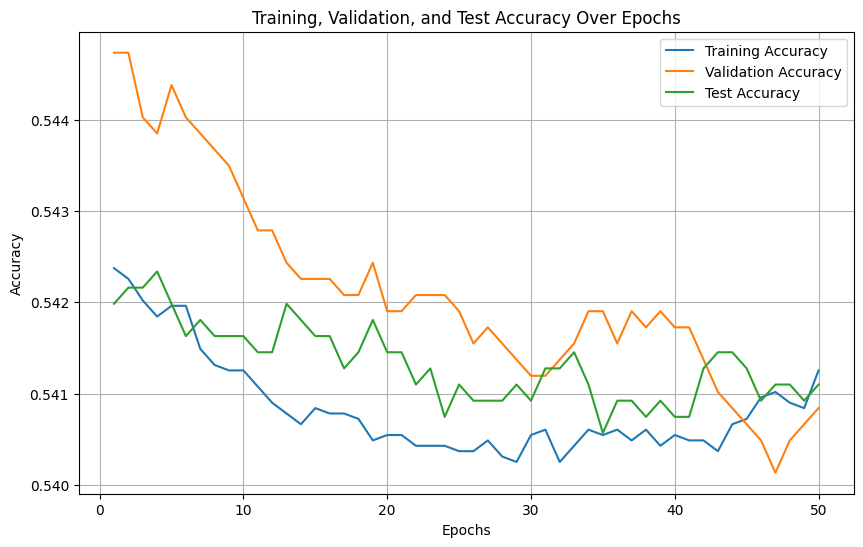

In [99]:
epoch_acc_plot(range(1, 51), train_acc_list, val_acc_list, test_acc_list)

In [ ]:
study_before_feather = optuna.create_study(direction='maximize')

study_before_feather.optimize(lambda trial: objectiveWithEmbedding(trial, data_DeezerEurope, feather_embedding_DeezerEurope, BeforeGraphSAGE), n_trials=25)

print("最佳参数: ", study_before_feather.best_params)
print("最佳测试准确率: ", study_before_feather.best_value)

In [ ]:
study_before_ASNE = optuna.create_study(direction='maximize')

study_before_ASNE.optimize(lambda trial: objectiveWithEmbedding(trial, data_DeezerEurope, ASNE_embedding_DeezerEurope, BeforeGraphSAGE), n_trials=25)

print("最佳参数: ", study_before_ASNE.best_params)
print("最佳测试准确率: ", study_before_ASNE.best_value)

In [ ]:
study_before_BANE = optuna.create_study(direction='maximize')

study_before_BANE.optimize(lambda trial: objectiveWithEmbedding(trial, data_DeezerEurope, BANE_embedding_DeezerEurope, BeforeGraphSAGE), n_trials=25)

print("最佳参数: ", study_before_BANE.best_params)
print("最佳测试准确率: ", study_before_BANE.best_value)

#### Parallel

In [100]:
class ParallelGraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, Attributed_node_embedding):
        super().__init__()
        self.SAGEconv1 = SAGEConv(in_channels, hidden_channels)
        self.SAGEconv2 = SAGEConv(hidden_channels, out_channels)
        self.linear = torch.nn.Linear(Attributed_node_embedding.shape[1], out_channels)
        self.act = torch.nn.ReLU()

    def forward(self,node_feature, edge_index, Attributed_node_embedding):
        output = self.SAGEconv1(node_feature, edge_index)
        output = self.act(output)
        output = self.SAGEconv2(output, edge_index)
        emb = self.linear(torch.tensor(Attributed_node_embedding, dtype=torch.float))
        return output+emb

##### Twitch

In [101]:
import torch.optim as optim
import torch.nn as nn

hidden_channels = 64
num_features = num_features_TwitchDE
num_classes = get_num_classes(data_TwitchDE) # please write down the number of classes

feather_parallel_twitch = ParallelGraphSAGE(num_features, hidden_channels, num_classes, feather_embedding_TwitchDE)
optimizer = optim.Adam(feather_parallel_twitch.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
train_acc_list=[]
val_acc_list=[]
test_acc_list=[]

epochs = 50
best_val_acc = final_test_acc = 0
for epoch in range(1, epochs + 1):
    loss = trainWithEmbedding(feather_parallel_twitch, data_TwitchDE, optimizer, loss_fn, feather_embedding_TwitchDE)
    #print(loss)
    train_acc, val_acc, test_acc = testWithEmbedding(feather_parallel_twitch, data_TwitchDE, feather_embedding_TwitchDE)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    test_acc_list.append(test_acc)
    #print(train_acc, val_acc, test_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        final_test_acc = test_acc
len_test_list = len(test_acc_list)
mean_value = np.mean(test_acc_list)
std_error = np.std(test_acc_list) / np.sqrt(len_test_list)
print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))
print("after {} epochs' training, the mean test accuracy is {}".format(epochs, mean_value))
print("after {} epochs' training, the standard error of accuracy is {}".format(epochs, std_error))

after 50 epochs' training, the best test accuracy is 0.60599684715271
after 50 epochs' training, the mean test accuracy is 0.5972540974617004
after 50 epochs' training, the standard error of accuracy is 0.0008897230013697097


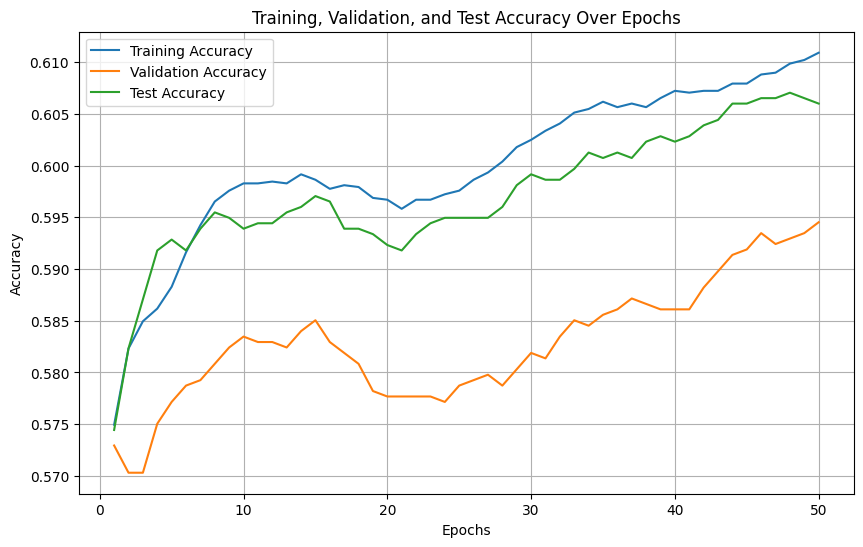

In [102]:
epoch_acc_plot(range(1, 51), train_acc_list, val_acc_list, test_acc_list)

In [103]:
hidden_channels = 64
num_features = num_features_TwitchDE
num_classes = get_num_classes(data_TwitchDE) # please write down the number of classes

ASNE_parallel_twitch = ParallelGraphSAGE(num_features, hidden_channels, num_classes, ASNE_embedding_TwitchDE)
optimizer = optim.Adam(ASNE_parallel_twitch.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
train_acc_list=[]
val_acc_list=[]
test_acc_list=[]

epochs = 50
best_val_acc = final_test_acc = 0
for epoch in range(1, epochs + 1):
    loss = trainWithEmbedding(ASNE_parallel_twitch, data_TwitchDE, optimizer, loss_fn, ASNE_embedding_TwitchDE)
    #print(loss)
    train_acc, val_acc, test_acc = testWithEmbedding(ASNE_parallel_twitch, data_TwitchDE, ASNE_embedding_TwitchDE)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    test_acc_list.append(test_acc)
    #print(train_acc, val_acc, test_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        final_test_acc = test_acc
len_test_list = len(test_acc_list)
mean_value = np.mean(test_acc_list)
std_error = np.std(test_acc_list) / np.sqrt(len_test_list)
print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))
print("after {} epochs' training, the mean test accuracy is {}".format(epochs, mean_value))
print("after {} epochs' training, the standard error of accuracy is {}".format(epochs, std_error))

after 50 epochs' training, the best test accuracy is 0.546554446220398
after 50 epochs' training, the mean test accuracy is 0.5243451595306396
after 50 epochs' training, the standard error of accuracy is 0.0017666321754119933


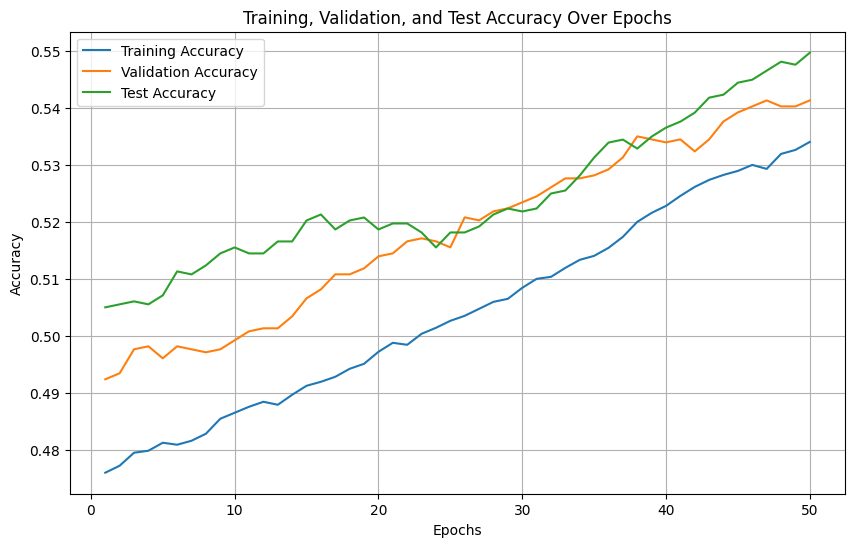

In [104]:
epoch_acc_plot(range(1, 51), train_acc_list, val_acc_list, test_acc_list)

In [105]:
hidden_channels = 64
num_features = num_features_TwitchDE
num_classes = get_num_classes(data_TwitchDE) # please write down the number of classes

BANE_parallel_twitch = ParallelGraphSAGE(num_features, hidden_channels, num_classes, BANE_embedding_TwitchDE)
optimizer = optim.Adam(BANE_parallel_twitch.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
train_acc_list=[]
val_acc_list=[]
test_acc_list=[]

epochs = 50
best_val_acc = final_test_acc = 0
for epoch in range(1, epochs + 1):
    loss = trainWithEmbedding(BANE_parallel_twitch, data_TwitchDE, optimizer, loss_fn, BANE_embedding_TwitchDE)
    #print(loss)
    train_acc, val_acc, test_acc = testWithEmbedding(BANE_parallel_twitch, data_TwitchDE, BANE_embedding_TwitchDE)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    test_acc_list.append(test_acc)
    #print(train_acc, val_acc, test_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        final_test_acc = test_acc
len_test_list = len(test_acc_list)
mean_value = np.mean(test_acc_list)
std_error = np.std(test_acc_list) / np.sqrt(len_test_list)
print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))
print("after {} epochs' training, the mean test accuracy is {}".format(epochs, mean_value))
print("after {} epochs' training, the standard error of accuracy is {}".format(epochs, std_error))

after 50 epochs' training, the best test accuracy is 0.4076801538467407
after 50 epochs' training, the mean test accuracy is 0.39950549602508545
after 50 epochs' training, the standard error of accuracy is 0.0010037513000159335


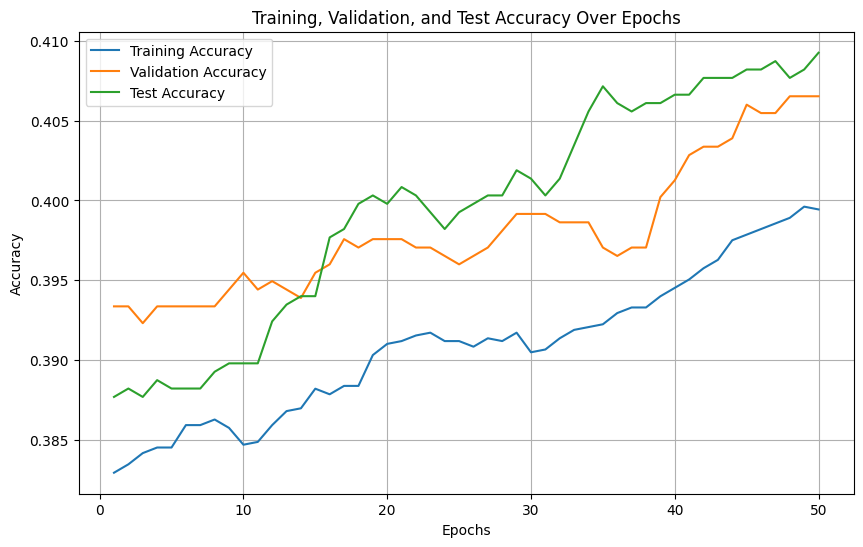

In [106]:
epoch_acc_plot(range(1, 51), train_acc_list, val_acc_list, test_acc_list)

In [ ]:
study_parallel_feather = optuna.create_study(direction='maximize')

study_parallel_feather.optimize(lambda trial: objectiveWithEmbedding(trial, data_TwitchDE, feather_embedding_TwitchDE, ParallelGraphSAGE), n_trials=25)

print("最佳参数: ", study_parallel_feather.best_params)
print("最佳测试准确率: ", study_parallel_feather.best_value)

In [ ]:
study_parallel_ASNE = optuna.create_study(direction='maximize')

study_parallel_ASNE.optimize(lambda trial: objectiveWithEmbedding(trial, data_TwitchDE, ASNE_embedding_TwitchDE, ParallelGraphSAGE), n_trials=25)

print("最佳参数: ", study_parallel_ASNE.best_params)
print("最佳测试准确率: ", study_parallel_ASNE.best_value)

In [ ]:
study_parallel_BANE = optuna.create_study(direction='maximize')

study_parallel_BANE.optimize(lambda trial: objectiveWithEmbedding(trial, data_TwitchDE, BANE_embedding_TwitchDE, ParallelGraphSAGE), n_trials=25)

print("最佳参数: ", study_parallel_BANE.best_params)
print("最佳测试准确率: ", study_parallel_BANE.best_value)

##### Deezer

In [108]:
import torch.optim as optim
import torch.nn as nn

hidden_channels = 64
num_features = num_features_DeezerEurope
num_classes = get_num_classes(data_DeezerEurope) # please write down the number of classes

feather_parallel_deezer = ParallelGraphSAGE(num_features, hidden_channels, num_classes, feather_embedding_DeezerEurope)
optimizer = optim.Adam(feather_parallel_deezer.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
train_acc_list=[]
val_acc_list=[]
test_acc_list=[]


epochs = 50
best_val_acc = final_test_acc = 0
for epoch in range(1, epochs + 1):
    loss = trainWithEmbedding(feather_parallel_deezer, data_DeezerEurope, optimizer, loss_fn, feather_embedding_DeezerEurope)
    #print(loss)
    train_acc, val_acc, test_acc = testWithEmbedding(feather_parallel_deezer, data_DeezerEurope, feather_embedding_DeezerEurope)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    test_acc_list.append(test_acc)
    #print(train_acc, val_acc, test_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        final_test_acc = test_acc
len_test_list = len(test_acc_list)
mean_value = np.mean(test_acc_list)
std_error = np.std(test_acc_list) / np.sqrt(len_test_list)
print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))
print("after {} epochs' training, the mean test accuracy is {}".format(epochs, mean_value))
print("after {} epochs' training, the standard error of accuracy is {}".format(epochs, std_error))

after 50 epochs' training, the best test accuracy is 0.5174120664596558
after 50 epochs' training, the mean test accuracy is 0.4968039393424988
after 50 epochs' training, the standard error of accuracy is 0.0033082757806853287


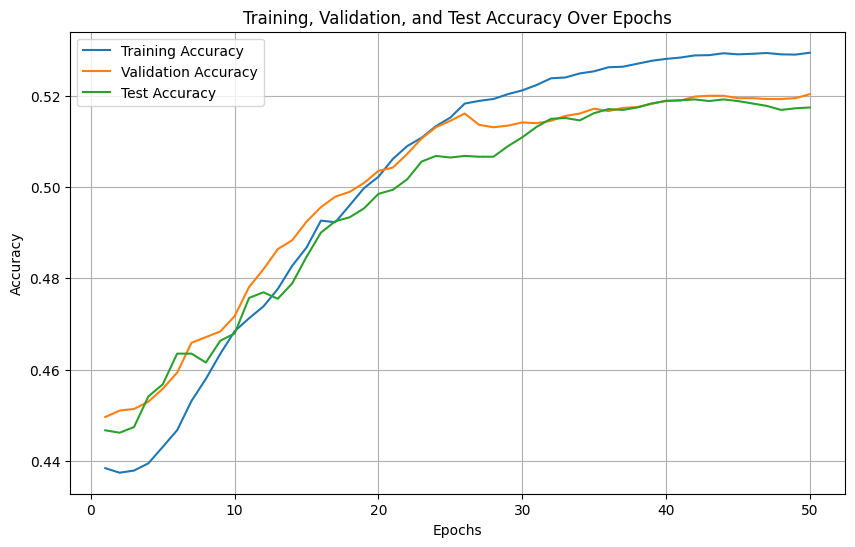

In [109]:
epoch_acc_plot(range(1, 51), train_acc_list, val_acc_list, test_acc_list)

In [110]:
hidden_channels = 64
num_features = num_features_DeezerEurope
num_classes = get_num_classes(data_DeezerEurope) # please write down the number of classes

ASNE_parallel_deezer = ParallelGraphSAGE(num_features, hidden_channels, num_classes, ASNE_embedding_DeezerEurope)
optimizer = optim.Adam(ASNE_parallel_deezer.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
train_acc_list=[]
val_acc_list=[]
test_acc_list=[]

epochs = 50
best_val_acc = final_test_acc = 0
for epoch in range(1, epochs + 1):
    loss = trainWithEmbedding(ASNE_parallel_deezer, data_DeezerEurope, optimizer, loss_fn, ASNE_embedding_DeezerEurope)
    #print(loss)
    train_acc, val_acc, test_acc = testWithEmbedding(ASNE_parallel_deezer, data_DeezerEurope, ASNE_embedding_DeezerEurope)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    test_acc_list.append(test_acc)
    #print(train_acc, val_acc, test_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        final_test_acc = test_acc
len_test_list = len(test_acc_list)
mean_value = np.mean(test_acc_list)
std_error = np.std(test_acc_list) / np.sqrt(len_test_list)
print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))
print("after {} epochs' training, the mean test accuracy is {}".format(epochs, mean_value))
print("after {} epochs' training, the standard error of accuracy is {}".format(epochs, std_error))

after 50 epochs' training, the best test accuracy is 0.4726887047290802
after 50 epochs' training, the mean test accuracy is 0.4630369544029236
after 50 epochs' training, the standard error of accuracy is 0.0007027622155534157


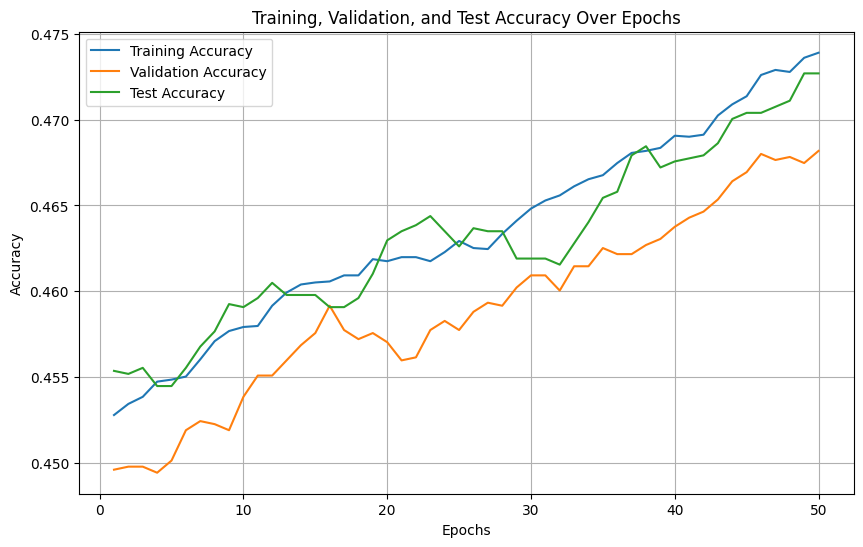

In [111]:
epoch_acc_plot(range(1, 51), train_acc_list, val_acc_list, test_acc_list)

In [112]:
hidden_channels = 64
num_features = num_features_DeezerEurope
num_classes = get_num_classes(data_DeezerEurope) # please write down the number of classes

BANE_parallel_deezer = ParallelGraphSAGE(num_features, hidden_channels, num_classes, BANE_embedding_DeezerEurope)
optimizer = optim.Adam(BANE_parallel_deezer.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
train_acc_list=[]
val_acc_list=[]
test_acc_list=[]

epochs = 50
best_val_acc = final_test_acc = 0
for epoch in range(1, epochs + 1):
    loss = trainWithEmbedding(BANE_parallel_deezer, data_DeezerEurope, optimizer, loss_fn, BANE_embedding_DeezerEurope)
    #print(loss)
    train_acc, val_acc, test_acc = testWithEmbedding(BANE_parallel_deezer, data_DeezerEurope, BANE_embedding_DeezerEurope)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    test_acc_list.append(test_acc)
    #print(train_acc, val_acc, test_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        final_test_acc = test_acc
len_test_list = len(test_acc_list)
mean_value = np.mean(test_acc_list)
std_error = np.std(test_acc_list) / np.sqrt(len_test_list)
print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))
print("after {} epochs' training, the mean test accuracy is {}".format(epochs, mean_value))
print("after {} epochs' training, the standard error of accuracy is {}".format(epochs, std_error))

after 50 epochs' training, the best test accuracy is 0.5228919982910156
after 50 epochs' training, the mean test accuracy is 0.5188403725624084
after 50 epochs' training, the standard error of accuracy is 0.00040504553753274025


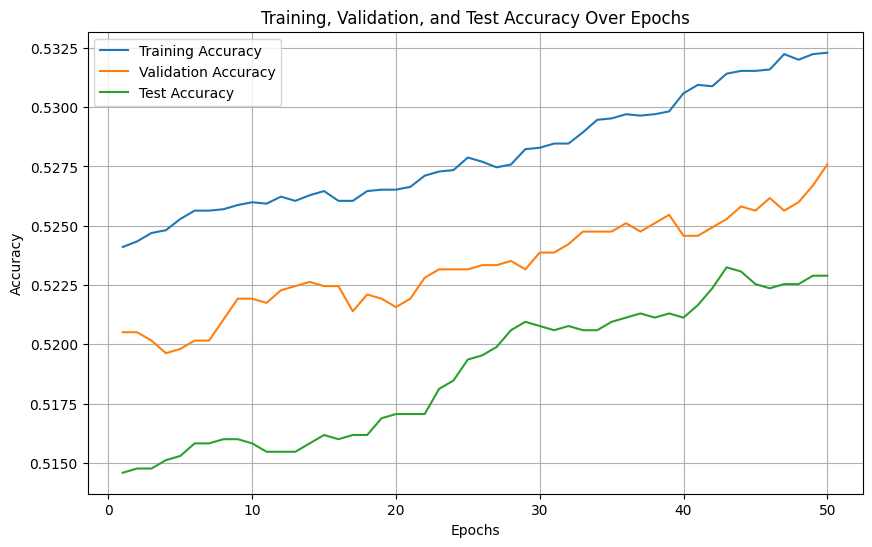

In [113]:
epoch_acc_plot(range(1, 51), train_acc_list, val_acc_list, test_acc_list)

In [ ]:
study_parallel_feather = optuna.create_study(direction='maximize')

study_parallel_feather.optimize(lambda trial: objectiveWithEmbedding(trial, data_DeezerEurope, feather_embedding_DeezerEurope, ParallelGraphSAGE), n_trials=25)

print("最佳参数: ", study_parallel_feather.best_params)
print("最佳测试准确率: ", study_parallel_feather.best_value)

In [ ]:
study_parallel_ASNE = optuna.create_study(direction='maximize')

study_parallel_ASNE.optimize(lambda trial: objectiveWithEmbedding(trial, data_DeezerEurope, ASNE_embedding_DeezerEurope, ParallelGraphSAGE), n_trials=25)

print("最佳参数: ", study_parallel_ASNE.best_params)
print("最佳测试准确率: ", study_parallel_ASNE.best_value)

In [ ]:
study_parallel_BANE = optuna.create_study(direction='maximize')

study_parallel_BANE.optimize(lambda trial: objectiveWithEmbedding(trial, data_DeezerEurope, BANE_embedding_DeezerEurope, ParallelGraphSAGE), n_trials=25)

print("最佳参数: ", study_parallel_BANE.best_params)
print("最佳测试准确率: ", study_parallel_BANE.best_value)